In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import os
import pickle
import tqdm
import numpy
from scipy import interpolate, optimize, integrate
from astropy.io import ascii
from astropy.table import Table
import healpy
from apogee.util import localfehdist
import gaia_tools.load, gaia_tools.select
from galpy.util import bovy_plot, bovy_coords, save_pickles, multi
from isodist import imf
from isodist import PadovaIsochrone
from apogee.util import localfehdist
from isodist import Z2FEH
import bovy_mcmc
import mwdust
import effsel
from effsel import main_sequence_cut_r, giant_sequence_cut
%pylab inline
import seaborn as sns
from matplotlib import cm
from matplotlib.ticker import NullFormatter, FuncFormatter, LogFormatter
from matplotlib.colors import LogNorm
from matplotlib import gridspec
import matplotlib.lines as mlines
import copy
save_figures= False
save_tables= False
numpy.random.seed(3)
nside= 2**5

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

Populating the interactive namespace from numpy and matplotlib


# Stellar densities in the solar neighborhood

In this notebook, we determine stellar densities for different stellar types in the solar neighborhood by using the star counts in *TGAS* and the effective-volume completeness. First we load the *TGAS* data and the selection function.

In [3]:
sp= effsel.load_spectral_types()
tgas= gaia_tools.load.tgas()
twomass= gaia_tools.load.twomass()
jk= twomass['j_mag']-twomass['k_mag']
dm= -5.*numpy.log10(tgas['parallax'])+10.
mj= twomass['j_mag']-dm
tsf= gaia_tools.select.tgasSelect()
# Cut to 'good' part
indx= tsf.determine_statistical(tgas,twomass['j_mag'],twomass['k_mag'])
tgas= tgas[indx]
twomass= twomass[indx]
jk= jk[indx]
dm= dm[indx]
mj= mj[indx]
XYZ= bovy_coords.lbd_to_XYZ(tgas['l'],tgas['b'],1./tgas['parallax'],degree=True)
dataXY= numpy.sqrt(XYZ[:,0]**2.+XYZ[:,1]**2.)
dataZ= XYZ[:,2]
print("%i stars in TGAS in the 'good' part of the sky" % (len(tgas)))

1192619 stars in TGAS in the 'good' part of the sky


Now, let's look at the color-magnitude diagram for stars in the 'good' part of the sky with parallaxes larger than a value such that the relative parallax uncertainty is smaller than 20%:

In [4]:
min_plx= 0.45/0.2
max_dist= 1./min_plx
print("%i stars in TGAS in the 'good' part of the sky with good parallax uncertainties" \
      % numpy.sum(tgas['parallax'] > min_plx))

442880 stars in TGAS in the 'good' part of the sky with good parallax uncertainties


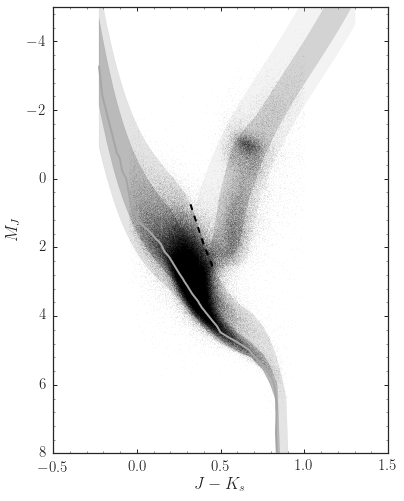

In [5]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,8)
# Select stars with 'good' parallaxes (somewhat circularly depending on their absolute magnitude...)
good_plx_indx= (tgas['parallax'] > min_plx)*(jk != 0.)
bovy_plot.bovy_plot((twomass['j_mag']-twomass['k_mag'])[good_plx_indx],
                    (twomass['j_mag']-dm)[good_plx_indx],
                    'k,',rasterized=True,
                    xrange=[-0.5,1.5],yrange=[8.,-5.],alpha=0.03,zorder=3,
                    xlabel=r'$J-K_s$',ylabel=r'$M_J$',clabel=r'$\varpi/\sigma_\varpi$')
sp_indx= numpy.array([(not 'O' in s)*(not 'L' in s)*(not 'T' in s)*(not 'Y' in s)\
                      *(not '.5V' in s) for s in sp['SpT']],dtype='bool')
bovy_plot.bovy_plot((sp['JH']+sp['HK'])[sp_indx],sp['M_J'][sp_indx],
                    color='0.65',lw=2.,zorder=4,overplot=True)
# Cuts
sp_indx= numpy.array([(not 'O' in s)*(not 'L' in s)*(not 'T' in s) for s in sp['SpT']],dtype='bool')
pyplot.fill_between((sp['JH']+sp['HK'])[sp_indx],main_sequence_cut_r((sp['JH']+sp['HK'])[sp_indx]),
                    main_sequence_cut_r((sp['JH']+sp['HK'])[sp_indx],low=True),
                    color='0.65',zorder=1,alpha=0.3)
pyplot.fill_between((sp['JH']+sp['HK'])[sp_indx],main_sequence_cut_r((sp['JH']+sp['HK'])[sp_indx],tight=True),
                    main_sequence_cut_r((sp['JH']+sp['HK'])[sp_indx],tight=True,low=True),
                    color='0.35',zorder=1,alpha=0.3)
jks= numpy.linspace(0.32,1.3,101)
pyplot.fill_between(jks,giant_sequence_cut(jks,tight=False),giant_sequence_cut(jks,tight=False,low=True),
                    color='0.85',zorder=1,alpha=0.3)
pyplot.fill_between(jks,giant_sequence_cut(jks,tight=True),giant_sequence_cut(jks,tight=True,low=True),
                    color='0.55',zorder=1,alpha=0.3)
jks= numpy.linspace(0.32,0.45,101)
plot(jks,giant_sequence_cut(jks,tight=False,low=True),'k--',lw=2.)

Even though we did not cut explicitly on relative parallax uncertainty, this looks pretty good!

## Stellar densities along the main sequence

Now, let's simply plot the number of stars in different stellar types along the main sequence in this sample.

In [6]:
sp_indx= numpy.array([(not 'O' in s)*(not 'L' in s)*(not 'T' in s)\
                          *(not 'Y' in s)\
                          *(not '.5V' in s) for s in sp['SpT']],
                     dtype='bool')
# Cut out the small part where the color decreases                              
sp_indx*= (numpy.roll((sp['JH']+sp['HK']),1)-(sp['JH']+sp['HK'])) <= 0.
# Also cut out B 
sp_indx*= numpy.array([(not 'B' in s) for s in sp['SpT']],dtype='bool') 
# JK boundaries
sub_indx= numpy.zeros_like(sp_indx)
sub_indx[sp_indx]= True
sub_indx[numpy.arange(len(sp_indx)) == (numpy.amin(numpy.arange(len(sp_indx))[sp_indx])-1)]= True
sub_indx[numpy.arange(len(sp_indx)) == (numpy.amax(numpy.arange(len(sp_indx))[sp_indx])+1)]= True
sp_jk= (sp['JH']+sp['HK'])[sub_indx]
sp_jkmin= sp_jk+0.5*(numpy.roll(sp_jk,1)-sp_jk)
sp_jkmax= sp_jk+0.5*(numpy.roll(sp_jk,-1)-sp_jk)
sp_jk_bins= list(sp_jkmin[1:])
sp_jk_mid= 0.5*(sp_jkmin+sp_jkmax)[1:-1]
# MJ
sp_mj= sp['M_J'][sub_indx]
sp_mjmin= sp_mj+0.5*(numpy.roll(sp_mj,1)-sp_mj)
sp_mjmax= sp_mj+0.5*(numpy.roll(sp_mj,-1)-sp_mj)
sp_mj= sp_mj[1:-1]
sp_mjmax= sp_mjmax[1:-1]
sp_mjmin= sp_mjmin[1:-1]
# MJ
sp_mv= sp['Mv'][sub_indx]
sp_mvmin= sp_mv+0.5*(numpy.roll(sp_mv,1)-sp_mv)
sp_mvmax= sp_mv+0.5*(numpy.roll(sp_mv,-1)-sp_mv)
sp_mv= sp_mv[1:-1]
sp_mvmax= sp_mvmax[1:-1]
sp_mvmin= sp_mvmin[1:-1]
# Masses
sp_mass= sp['Msun'][sub_indx]
sp_massmax= sp_mass+0.5*(numpy.roll(sp_mass,1)-sp_mass)
sp_massmin= sp_mass+0.5*(numpy.roll(sp_mass,-1)-sp_mass)
sp_mass= sp_mass[1:-1]
sp_massmax= sp_massmax[1:-1]
sp_massmin= sp_massmin[1:-1]
# Ages
sp_lage= sp['logAge'][sub_indx]
sp_lagemin= sp_lage+0.5*(numpy.roll(sp_lage,1)-sp_lage)
sp_lagemax= sp_lage+0.5*(numpy.roll(sp_lage,-1)-sp_lage)
sp_lage= sp_lage[1:-1]
sp_lagemax= sp_lagemax[1:-1]
sp_lagemin= sp_lagemin[1:-1]
# Spectral types
sp_type= sp['SpT'][sub_indx]

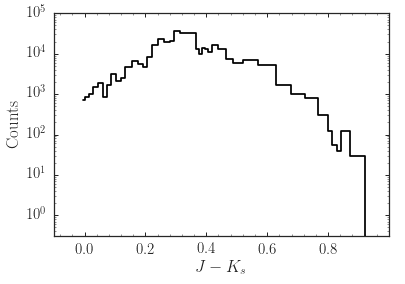

In [7]:
figsize(6,4)
good_plx_indx*= (mj > main_sequence_cut_r(jk))*(mj < main_sequence_cut_r(jk,low=True))
counts, edges= numpy.histogram(jk[good_plx_indx],bins=sp_jk_bins)
bovy_plot.bovy_plot(sp_jk_mid,counts,ls='steps-mid',color='k',semilogy=True,
                   xrange=[-0.1,1.],yrange=[.3,10.**5.],
                   xlabel=r'$J-K_s$',ylabel=r'$\mathrm{Counts}$')

As a reminder, here's how color maps to stellar type:

(-1.0, 49.0)

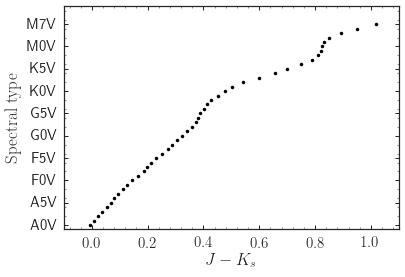

In [8]:
figsize(6,4)
bovy_plot.bovy_plot(sp_jk_mid,numpy.arange(len(sp_jk_mid)),'k.',lw=2.,
                   xlabel=r'$J-K_s$',ylabel=r'$\mathrm{Spectral\ type}$')
gca().yaxis.set_ticks(numpy.arange(numpy.sum(sp_indx))[::5])
_= gca().yaxis.set_ticklabels(sp['SpT'][sp_indx][0::5])
xlim(-0.1,1.1)
ylim(-1.,49.)

Let's start by looking at the vertical number counts of K dwarfs close to the plane. Intrinsically, these should be pretty flat, so the observed number counts should simply reflect the selection function and thus act as a check on the selection function.

In [9]:
def cyl_vol_func(X,Y,Z,xymin=0.,xymax=0.15,zmin=0.05,zmax=0.15):
    """A function that bins in cylindrical annuli around the Sun"""
    xy= numpy.sqrt(X**2.+Y**2.)
    out= numpy.zeros_like(X)
    out[(xy >= xymin)*(xy < xymax)*(Z >= zmin)*(Z < zmax)]= 1.
    return out
def good_relplx(mj):
    out= numpy.empty_like(mj)
    out[mj > 5.]= 20.
    out[mj < 0.]= 10.
    out[(mj >= 0)*(mj <= 5.)]= 20.+2.*(mj[(mj >= 0)*(mj <= 5.)]-5.)
    return out
def vertical_counts_onepop(zbins,
                           xy_data,z_data,
                           jk,mj,spt,
                           maxxy=0.2,
                           cutbright=False):
    # Compute the effective volume, if cutbright, cut out the bright end where the selfunc is poor
    good_mj_indx= (mj > main_sequence_cut_r(jk,tight=True))*(mj < main_sequence_cut_r(jk,low=True,tight=True))
    if numpy.sum(good_mj_indx) < 50:
        MJ= mj
        JK= jk
    else:
        MJ= mj[good_mj_indx]
        JK= jk[good_mj_indx]
    if cutbright:
        tjk= numpy.median(JK)
        tjmin= 8.-(tjk**2.+2.5*tjk)
        tsf._jmin= tjmin
    else:
        tsf._jmin= 2.
    tesf= gaia_tools.select.tgasEffectiveSelect(tsf,dmap3d=mwdust.Zero(),MJ=MJ,JK=JK,maxd=max_dist)
    evfs= numpy.empty(len(zbins)-1)
    ndists=2501*('A' in spt) + 1001 * (True-('A' in spt))
    if spt == 'giant': ndists= 2501
    for jj in range(len(zbins)-1):
        evfs[jj]= tesf.volume(lambda x,y,z: cyl_vol_func(x,y,z,xymax=maxxy,zmin=zbins[jj],zmax=zbins[jj+1]),
                              ndists=ndists,xyz=True,relative=True)
    evfs*= numpy.pi*maxxy**2.*(numpy.roll(zbins,-1)-zbins)[:-1]
    counts, _= numpy.histogram(z_data[xy_data < maxxy],bins=zbins)
    return (counts/evfs, numpy.sqrt(counts)/evfs,evfs)

In [10]:
ii= 35
dii= 5
print(sp_jk_bins[ii],sp_jk_bins[ii+dii],sp['SpT'][sp_indx][ii],sp['SpT'][sp_indx][ii+dii])
tindx= (jk > sp_jk_bins[ii])*(jk < sp_jk_bins[ii+dii])\
        *(tgas['parallax'] > min_plx)*(jk != 0.)\
        *(mj > main_sequence_cut_r(jk))*(mj < main_sequence_cut_r(jk,low=True))
good_relplx_indx= (jk > sp_jk_bins[ii])*(jk < sp_jk_bins[ii+dii])\
                    *(tgas['parallax']/tgas['parallax_error'] > (good_relplx(mj)))*(jk != 0.)
zbins= numpy.arange(-0.3125,0.325,0.025)
c,ec,ef= vertical_counts_onepop(zbins,dataXY[tindx],dataZ[tindx],
                             jk[good_relplx_indx],mj[good_relplx_indx],
                             sp['SpT'][sp_indx][ii],maxxy=0.1)

(0.67949999999999999, 0.82350000000000001, 'K5V', 'M0V')


/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:898: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))



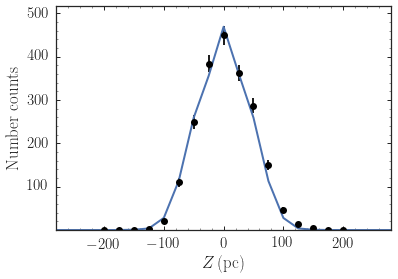

In [11]:
figsize(6,4)
fac= numpy.median(c[11:-11])
bovy_plot.bovy_plot(500.*(numpy.roll(zbins,-1)+zbins)[:-1],ef*fac,'-',
                    color=sns.color_palette()[0],semilogy=False,
                    lw=2.,zorder=2,
                    xlabel=r'$Z\,(\mathrm{pc})$',
                    ylabel=r'$\mathrm{Number\ counts}$',
                    xrange=[-280,280],
#                    yrange=[1.,5.1*numpy.amax(ef*fac)])
                    yrange=[1.,1.1*numpy.amax(ef*fac)])
errorbar(500.*(numpy.roll(zbins,-1)+zbins)[:-1],c*ef,yerr=ec*ef,color='k',marker='o',
        ls='None')
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','numcounts_latek.pdf'),
                bbox_inches='tight')

(0.0062953777237089621, 0.0047395845680575964, 0.64000000000000001, 0.0030333341235568617, 0.0040290417431737358)


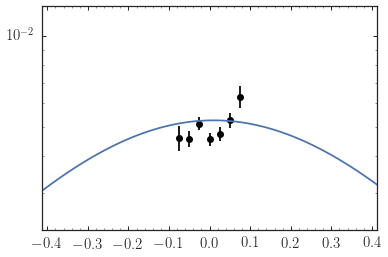

In [12]:
good_dens_indx= (ef > 0.1*numpy.nanmax(ef))
bovy_plot.bovy_plot(0.5*(numpy.roll(zbins,-1)+zbins)[:-1][good_dens_indx],c[good_dens_indx]/10.**9.,'ko',
                    yrange=[0.5*numpy.nanmin(c[good_dens_indx]/10.**9.),2.*numpy.nanmax(c[good_dens_indx]/10.**9.)],
                    semilogy=True,
                    xrange=[zbins[0]-0.1,zbins[-1]+0.1])
errorbar(0.5*(numpy.roll(zbins,-1)+zbins)[:-1][good_dens_indx],c[good_dens_indx]/10.**9.,
         ec[good_dens_indx]/10.**9.,marker='None',ls='None',color='k')
zs= numpy.linspace(-0.45,0.45,101)
amp= numpy.nanmax(c[good_dens_indx]/10.**9.)
plot(zs,1./numpy.cosh((zs-0.01)/2./0.275)**2.*amp/1.2)
print(amp,numpy.median(c[good_dens_indx]/10.**9.),
      numpy.median(sp['Msun'][sp_indx][ii:ii+dii]),
      numpy.median(c[good_dens_indx]/10.**9.)*numpy.median(sp['Msun'][sp_indx][ii:ii+dii]),
     amp*numpy.median(sp['Msun'][sp_indx][ii:ii+dii]))

Code to fit vertical density profiles:

In [13]:
sf_unc= 0.03
def sech2profile(z,p):
    amp= numpy.exp(p[0])
    hz= numpy.exp(p[1])
    zsun= p[2]
    if len(p) > 3:
        return amp*((1.-p[3])/numpy.cosh((z+zsun)/2./hz)**2.+p[3]/numpy.cosh((z+zsun)/2./numpy.exp(p[4]))**2.)
    else:
        return amp/numpy.cosh((z+zsun)/2./hz)**2.
def lnlike(p,c,ec,ef,zs):
    if p[2] < -0.05 or p[2] > 0.05: return -10000000000000000000000.
    if p[1] < numpy.log(0.025) or p[1] > numpy.log(10.): return -10000000000000000000000.
    if len(p) > 3 and (p[3] < 0. or p[3] > 0.5): return -10000000000000000000000.
    if len(p) > 3 and p[4] < p[1]: return -10000000000000000000000.
    return -0.5*numpy.sum((c-sech2profile(zs,p))**2./(ec**2.+(sf_unc*c)**2.))
def mlnlike(*args):
    return -lnlike(*args)
def fit_sech2(c,ec,ef,raw,zbins,verbose=True,include_outlier=False):
    good_dens_indx= (ef > sf_unc*numpy.nanmax(ef))*(c > 0.)*((ef == ef[len(ef)//2])+(ef > 10.**-5.))*(raw > 4.)
    if numpy.sum(good_dens_indx) == 0:
        return numpy.ones(3+2*include_outlier)*numpy.nan
    zs= 0.5*(numpy.roll(zbins,-1)+zbins)[:-1][good_dens_indx]
    init_p= [numpy.log(numpy.nanmax(c[good_dens_indx])),numpy.log(0.1),0.]
    if include_outlier:
        init_p.extend([0.01,numpy.log(0.3)])
    init_p= numpy.array(init_p)
    args= (c[good_dens_indx],ec[good_dens_indx],ef[good_dens_indx],zs)
    p= optimize.fmin_powell(mlnlike,init_p,args=args,disp=verbose)
    return p
def sample_sech2(c,ec,ef,raw,zbins,nsamples=10000,verbose=True,include_outlier=False,plots=False):
    good_dens_indx= (ef > sf_unc*numpy.nanmax(ef))*(c > 0.)*((ef == ef[len(ef)//2])+(ef > 10.**-5.))*(raw > 4.)
    if numpy.sum(good_dens_indx) == 0:
        return numpy.ones(3+2*include_outlier)*numpy.nan
    init_p= fit_sech2(c,ec,ef,raw,zbins,verbose=verbose,include_outlier=include_outlier)
    zs= 0.5*(numpy.roll(zbins,-1)+zbins)[:-1][good_dens_indx]
    args= (c[good_dens_indx],ec[good_dens_indx],ef[good_dens_indx],zs)
    isDomainFinite= [[False,False] for ii in range(len(init_p))]
    isDomainFinite[1]= [True,True]
    isDomainFinite[2]= [True,True]
    domain= [[0.,0.] for ii in range(len(init_p))]
    domain[1]= [numpy.log(0.025),numpy.log(10.)]
    domain[2]= [-0.05,0.05]
    if len(init_p) > 3:
        isDomainFinite[3]= [True,True]
        domain[3]= [0.,0.5]
        isDomainFinite[4]= [True,False]
        domain[4]= [init_p[1],0.]
    samples=\
        bovy_mcmc.markovpy(init_p,0.01,
                           lambda x: lnlike(x,*args),(),
                           isDomainFinite=isDomainFinite,
                           domain=domain,
                           nsamples=nsamples,
                           nwalkers=2*len(init_p))
    samples= numpy.array(samples).T
    if plots: plot_samples(samples)
    return samples
import corner
def plot_samples(samples):
    labels= [r'$\ln\rho_0$',r'$z_d\,(\mathrm{pc})$',r'$z_\odot\,(\mathrm{pc})$',r'$f$',r'$\ln z_\mathrm{out}$']
    ranges= [(-15.,-1.),(-4.,-1.),(-0.05,0.05),(0.,0.5),(-4.,100.)]
    labels= labels[:samples.shape[0]]
    ranges= ranges[:samples.shape[0]]
    plotsamples= copy.copy(samples)
    plotsamples[2]*= 1000.
    plotsamples[1]= numpy.exp(plotsamples[1])*1000.
    corner.corner(plotsamples.T,quantiles=[0.16, 0.5, 0.84],labels=labels,
                  show_titles=True, title_args={"fontsize": 12})#,range=ranges)

An example that has a non-trivial density profile (early F stars):

In [14]:
ii= 10
dii= 4
print(sp_jk_bins[ii],sp_jk_bins[ii+dii],sp['SpT'][sp_indx][ii],sp['SpT'][sp_indx][ii+dii])
tindx= (jk > sp_jk_bins[ii])*(jk < sp_jk_bins[ii+dii])\
        *(tgas['parallax'] > min_plx)*(jk != 0.)\
        *(mj > main_sequence_cut_r(jk))*(mj < main_sequence_cut_r(jk,low=True))
good_relplx_indx= (jk > sp_jk_bins[ii])*(jk < sp_jk_bins[ii+dii])\
                    *(tgas['parallax']/tgas['parallax_error'] > (good_relplx(mj)))*(jk != 0.)
zbins= numpy.arange(-0.4125,0.425,0.025)
c,ec,ef= vertical_counts_onepop(zbins,dataXY[tindx],dataZ[tindx],
                             jk[good_relplx_indx],mj[good_relplx_indx],
                             sp['SpT'][sp_indx][ii],maxxy=0.1)

(0.13200000000000001, 0.20449999999999999, 'F0V', 'F4V')


Optimization terminated successfully.
         Current function value: 13.985450
         Iterations: 8
         Function evaluations: 565


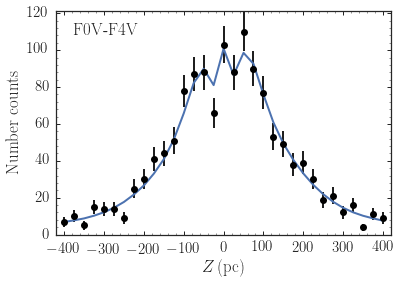

In [15]:
figsize(6,4)
p= fit_sech2(c,ec,ef,c*ef,zbins,verbose=True,include_outlier=True)
bovy_plot.bovy_plot(500.*(numpy.roll(zbins,-1)+zbins)[:-1],
                    sech2profile(0.5*(numpy.roll(zbins,-1)+zbins)[:-1],p)*ef,'-',
                    color=sns.color_palette()[0],semilogy=False,
                    lw=2.,zorder=2,
                    xlabel=r'$Z\,(\mathrm{pc})$',
                    ylabel=r'$\mathrm{Number\ counts}$',
                    xrange=[-420,420],
                    yrange=[0.,1.2*numpy.amax(sech2profile(0.5*(numpy.roll(zbins,-1)+zbins)[:-1],p)*ef)])
errorbar(500.*(numpy.roll(zbins,-1)+zbins)[:-1],c*ef,yerr=ec*ef,color='k',marker='o',
        ls='None')
bovy_plot.bovy_text(r'$\mathrm{F0V}\mbox{-}\mathrm{F4V}$',top_left=True,size=17.)
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','numcounts_earlyf.pdf'),
                bbox_inches='tight')

Fit all populations:

In [16]:
zbins= numpy.arange(-0.4125,0.425,0.025)
npop= 45
dpop= 1
savefilename= 'counts_vert_AthroughF_singlebins.sav' # 'counts_vert_AthroughF.sav' for dpop=2
def good_maxxy(spt):
    if 'A' in spt: maxxy= 0.25
    elif 'F' in spt: maxxy= 0.2
    elif 'G' in spt: maxxy= 0.15
    elif 'K' in spt: maxxy= 0.1
    elif 'M' in spt: maxxy= 0.025
    return maxxy
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        all_counts= pickle.load(savefile)
        all_counts_unc= pickle.load(savefile)
        all_effvol= pickle.load(savefile)
else:
    all_counts= numpy.empty((npop,len(zbins)-1))
    all_counts_unc= numpy.empty((npop,len(zbins)-1))
    all_effvol= numpy.empty((npop,len(zbins)-1))
    multiOut= multi.parallel_map(\
                lambda x: vertical_counts_onepop(zbins,
                                                 dataXY[(jk > sp_jk_bins[x])*(jk < sp_jk_bins[x+dpop])\
                                                         *(tgas['parallax'] > min_plx)*(jk != 0.)\
                                                         *(mj > main_sequence_cut_r(jk))\
                                                         *(mj < main_sequence_cut_r(jk,low=True))],
                                                 dataZ[(jk > sp_jk_bins[x])*(jk < sp_jk_bins[x+dpop])\
                                                         *(tgas['parallax'] > min_plx)*(jk != 0.)\
                                                         *(mj > main_sequence_cut_r(jk))\
                                                         *(mj < main_sequence_cut_r(jk,low=True))],
                                                 jk[(jk > sp_jk_bins[x])*(jk < sp_jk_bins[x+dpop])\
                                                    *(tgas['parallax']/tgas['parallax_error'] > (good_relplx(mj)))\
                                                    *(jk != 0.)],
                                                 mj[(jk > sp_jk_bins[x])*(jk < sp_jk_bins[x+dpop])\
                                                    *(tgas['parallax']/tgas['parallax_error'] > (good_relplx(mj)))\
                                                    *(jk != 0.)],
                                                 sp['SpT'][sp_indx][x],
                                                 maxxy=good_maxxy(sp['SpT'][sp_indx][x])),
                                range(npop),numcores=30)
    for ii in range(npop):
        all_counts[ii]= multiOut[ii][0]
        all_counts_unc[ii]= multiOut[ii][1]
        all_effvol[ii]= multiOut[ii][2]
    save_pickles(savefilename,all_counts,all_counts_unc,all_effvol)

In [17]:
nsamples= 10000
all_p= numpy.empty((npop,5))
all_s= numpy.empty((npop,5,nsamples))
all_s_med= numpy.empty((npop,5))
all_s_mad= numpy.empty((npop,5))
all_s_low= numpy.empty((npop,5))
all_s_high= numpy.empty((npop,5))
all_s_vlow= numpy.empty((npop,5))
all_s_vhigh= numpy.empty((npop,5))
for ii in tqdm.tqdm(range(npop)):
    c= all_counts[ii]
    ec= all_counts_unc[ii]
    raw= c*all_effvol[ii]
    ef= all_effvol[ii]/(good_maxxy(sp['SpT'][sp_indx][ii])**2.*numpy.pi*(zbins[1]-zbins[0]))
    all_p[ii]= fit_sech2(c,ec,ef,raw,zbins,verbose=False,include_outlier=True)
    ts= sample_sech2(c,ec,ef,raw,zbins,verbose=False,include_outlier=True,nsamples=nsamples)
    if len(ts.shape) == 1:
        all_s[ii,:,:]= numpy.nan
        all_s_med[ii,:]= numpy.nan
        all_s_mad[ii,:]= numpy.nan
        all_s_low[ii,:]= numpy.nan
        all_s_high[ii,:]= numpy.nan
    else:
        all_s[ii]= ts
        all_s_med[ii]= numpy.nanmedian(ts,axis=1)
        all_s_mad[ii]= numpy.nanmedian(numpy.fabs(ts.T-all_s_med[ii]).T,axis=1)
        for jj in range(len(all_s[ii])):
            all_s_low[ii,jj]= all_s[ii,jj,numpy.argsort(all_s[ii,jj])][int(numpy.floor(0.16*nsamples))]
            all_s_high[ii,jj]= all_s[ii,jj,numpy.argsort(all_s[ii,jj])][int(numpy.floor(0.84*nsamples))]            
            all_s_vlow[ii,jj]= all_s[ii,jj,numpy.argsort(all_s[ii,jj])][int(numpy.floor(0.01*nsamples))]
            all_s_vhigh[ii,jj]= all_s[ii,jj,numpy.argsort(all_s[ii,jj])][int(numpy.floor(0.99*nsamples))]            

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/MarkovPy-0.1-py2.7.egg/markovpy/ensemble.py:234: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if lnprob == None:



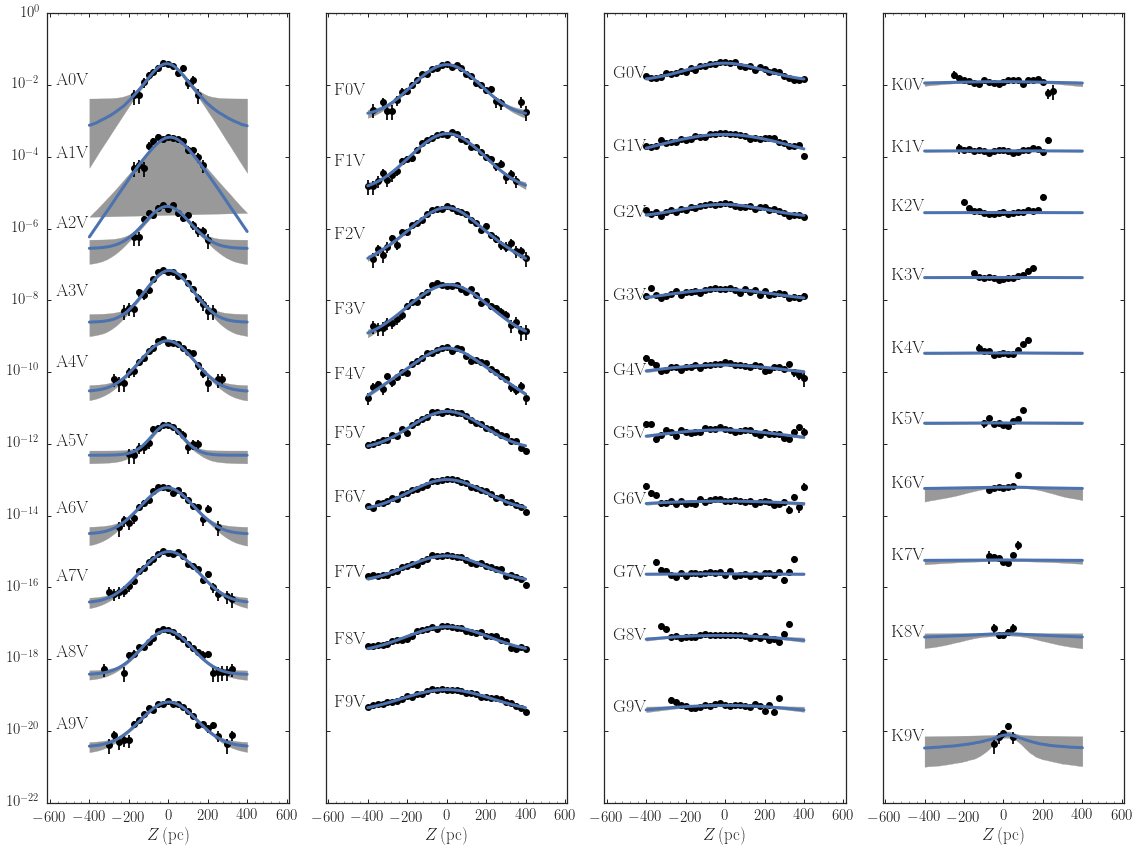

In [18]:
figsize(16,12)
npop_plot= 40
dii= dpop
zs= numpy.linspace(-0.4,0.4,101)
include_range= True
for ii in tqdm.tqdm(range(npop_plot)):
    c= all_counts[ii]
    ec= all_counts_unc[ii]
    raw= c*all_effvol[ii]
    ef= all_effvol[ii]/(good_maxxy(sp['SpT'][sp_indx][ii])**2.*numpy.pi*(zbins[1]-zbins[0]))
    good_dens_indx= (ef > sf_unc*numpy.nanmax(ef))*(c > 0.)*((ef == ef[len(ef)//2])+(ef > 10.**-5.))*(raw > 4.)
    subplot(1,4,ii//10+1)
    bovy_plot.bovy_plot(1000.*0.5*(numpy.roll(zbins,-1)+zbins)[:-1][good_dens_indx],
                        c[good_dens_indx]/10.**6./10**(2.*(ii%10))/10**((ii//10)/2.),
                        'ko',gcf=True,overplot=(ii%10 > 0),
                        yrange=[10.**-22.,10.**0.],
                        semilogy=True,
                        xrange=[1000.*(zbins[0]-0.2),1000.*(zbins[-1]+0.2)],
                        zorder=2,
                        xlabel=r'$Z\,(\mathrm{pc})$')
    errorbar(1000.*0.5*(numpy.roll(zbins,-1)+zbins)[:-1][good_dens_indx],
             c[good_dens_indx]/10.**6./10**(2.*(ii%10))/10**((ii//10)/2.),
             ec[good_dens_indx]/10.**6./10**(2.*(ii%10))/10**((ii//10)/2.),
             marker='None',ls='None',color='k',capsize=0,zorder=1)
    if include_range:
        s= sample_sech2(c,ec,ef,raw,zbins,include_outlier=True,plots=False,nsamples=10000,verbose=False)
        all_prof= sech2profile(numpy.tile(zs,(10000,1)),
                               numpy.tile(s.T,(len(zs),1,1)).T)/10.**6./10**(2.*(ii%10))/10**((ii//10)/2.)
        all_prof= numpy.sort(all_prof,axis=0)
        plot(1000.*zs,all_prof[int(numpy.floor(0.5*len(all_prof)))],color=sns.color_palette()[0],lw=3.)
        fill_between(1000.*zs,
                     all_prof[int(numpy.floor(0.16*len(all_prof)))],all_prof[int(numpy.floor(0.84*len(all_prof)))],
                    color='0.6',zorder=0)
    else:
        p= fit_sech2(c,ec,ef,raw,zbins,include_outlier=True,verbose=False)
        plot(1000.*zs,sech2profile(zs,p)/10.**6./10**(2.*(ii%10))/10**((ii//10)/2.),lw=3.,color=sns.color_palette()[0])
    if ii/10 > 0:
        gca().yaxis.set_major_formatter(NullFormatter())
    bovy_plot.bovy_text(-570.,
                        numpy.exp(0.5*(numpy.log(numpy.nanmax(c[good_dens_indx]))
                                       +numpy.log(numpy.nanmin(c[good_dens_indx]))))\
                            /10.**6./10**(2.*(ii%10))/10**((ii//10)/2.)/1.5,
                        r'$\mathrm{%s}$' % (sp['SpT'][sp_indx][ii]),size=18.)
tight_layout()
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','densprofiles.pdf'),
                bbox_inches='tight')

The number -density distribution in the mid-plane is:

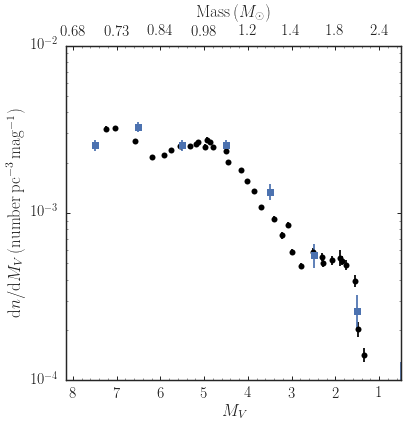

In [19]:
skip= 1
tnpop= 35
addrhg02= True
if False: # MJ
    dmj= sp_mjmax[:tnpop:skip]-sp_mjmin[skip-1:tnpop+skip-1:skip]
    mj_mid= sp_mj[1:tnpop+1:skip]
    sp_m= sp_mj
    txlabel=r'$M_J$'
    tylabel=r'$\mathrm{d} n / \mathrm{d} M_J\,(\mathrm{number\,pc}^{-3}\,\mathrm{mag}^{-1})$'
else: # MV
    dmj= sp_mvmax[:tnpop:skip]-sp_mvmin[skip-1:tnpop+skip-1:skip]
    mj_mid= sp_mv[1:tnpop+1:skip]
    sp_m= sp_mv
    txlabel=r'$M_V$'
    tylabel=r'$\mathrm{d} n / \mathrm{d} M_V\,(\mathrm{number\,pc}^{-3}\,\mathrm{mag}^{-1})$'
figsize(6,6)
bovy_plot.bovy_plot(mj_mid,
                    numpy.exp(all_p[:tnpop:skip,0]-9.*numpy.log(10.)-numpy.log(dmj)),
                    'ko',ms=6.,zorder=2,
                    semilogy=True,
                    xrange=[8.15,0.5],
                    yrange=[0.0001,0.01],
                   xlabel=txlabel,
                   ylabel=tylabel)
errorbar(mj_mid,
         numpy.exp(all_p[:tnpop:skip,0]-9.*numpy.log(10.)-numpy.log(dmj)),
         yerr=(numpy.exp(all_s_high[:tnpop:skip,0]-9.*numpy.log(10.)-numpy.log(dmj))
              -numpy.exp(all_s_low[:tnpop:skip,0]-9.*numpy.log(10.)-numpy.log(dmj)))/2.,
         marker='None',ls='None',color='k',zorder=1,capsize=0)
if addrhg02:
    rhg02_mv= numpy.arange(-0.5,18.5,1.)
    rhg02_phi= numpy.array([0.46,0.92,2.6,5.65,13.45,25.36,25.36,32.54,25.52,40.16,58.26,88.16,
                           91.06,107.30,92.31,50.93,248.28,76.39,76.39])/10.**4.
    rhg02_rawcounts= numpy.array([3,6,17,37,88,166,166,213,167,145,110,77,79,94,29,16,10,3,3])
    bovy_plot.bovy_plot(rhg02_mv,rhg02_phi,'s',overplot=True,color=sns.color_palette()[0])
    errorbar(rhg02_mv,rhg02_phi,yerr=rhg02_phi/numpy.sqrt(rhg02_rawcounts),
             marker='None',ls='None',color=sns.color_palette()[0],zorder=1,capsize=0)
# Put approximate masses at the top
ip= interpolate.InterpolatedUnivariateSpline(sp_m,sp_mass,k=3)
ax1= pyplot.gca()
ax2= pyplot.twiny()
ax2.xaxis.set_major_formatter(FuncFormatter(lambda y,pos: '$%.1f$' % ip(y) if ip(y) >= 1 else '$%.2f$' % ip(y)))
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel(r'$\mathrm{Mass}\,(M_\odot)$')
bovy_plot._add_ticks(xticks=True,yticks=False)
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','lumfunc.pdf'),
                bbox_inches='tight')

The mass distribution in the mid-plane is:

MF at 1 Msun = 0.0418, to be compared with Chabrier's 0.0443
('Expected mass in white dwarfs coming from 1 to 8 Msun <', 0.003510914711917657)
('Missing mass between 1 and 8 Msun: ', 0.026739822115250625)


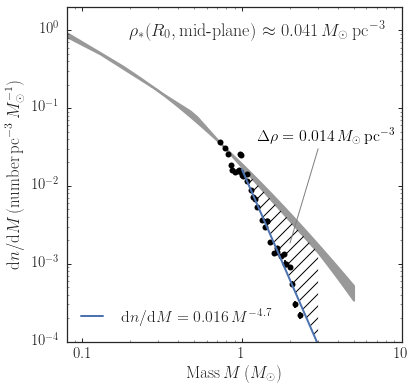

In [20]:
skip= 1
tnpop= 35
dm= sp_massmax[:tnpop:skip]-sp_massmin[skip-1:tnpop+skip-1:skip]
m_mid= sp_mass[:tnpop:skip]
figsize(6,6)
bovy_plot.bovy_plot(m_mid,
                    numpy.exp(all_p[:tnpop:skip,0]-9.*numpy.log(10.)-numpy.log(dm)),
                    'ko',ms=6.,zorder=2,
                    loglog=True,
                    xrange=[0.08,10.],
                    yrange=[0.0001,2.],
                   xlabel=r'$\mathrm{Mass}\, M\,(M_\odot)$',
                   ylabel=r'$\mathrm{d} n / \mathrm{d} M\,(\mathrm{number\,pc}^{-3}\,M_\odot^{-1})$')
errorbar(m_mid,
         numpy.exp(all_p[:tnpop:skip,0]-9.*numpy.log(10.)-numpy.log(dm)),
         yerr=(numpy.exp(all_s_high[:tnpop:skip,0]-9.*numpy.log(10.)-numpy.log(dm))
              -numpy.exp(all_s_low[:tnpop:skip,0]-9.*numpy.log(10.)-numpy.log(dm)))/2.,
         marker='None',ls='None',color='k',zorder=1,capsize=0)
ms= numpy.linspace(0.08,5.,101)
imfs= numpy.empty((len(ms),3))
totmass= numpy.empty(3)
for kk,imf_func in enumerate([imf.kroupa2003,imf.lognormalChabrier2001,imf.exponentialChabrier2001]):
    m_indx= numpy.fabs(m_mid-0.75) < 0.05
    fac= numpy.nanmedian((numpy.exp(all_p[:tnpop:skip,0][m_indx]-9.*numpy.log(10.)-numpy.log(dm[m_indx])))\
                         /imf_func(m_mid[m_indx]))
    imfs[:,kk]= imf_func(ms)*fac
    totmass[kk]= (integrate.quad(lambda m: m*imf_func(m)*fac,0.08,1.))[0]
fill_between(ms,numpy.amin(imfs,axis=1),numpy.amax(imfs,axis=1),color='0.6',lw=2.,zorder=0)
print("MF at 1 Msun = %.4f, to be compared with Chabrier's 0.0443" \
      % (numpy.median(imfs[numpy.argmin(numpy.fabs(ms-1.))])*numpy.log(10.)))
# Fit high-mass end
m_high_indx= m_mid > 1.
p= numpy.polyfit(numpy.log(m_mid[m_high_indx]),
                 numpy.log((numpy.exp(all_p[:tnpop:skip,0]-9.*numpy.log(10.)-numpy.log(dm)))[m_high_indx]),
                 w=(numpy.exp(all_p[:tnpop:skip,0]-9.*numpy.log(10.)-numpy.log(dm)))[m_high_indx]\
                 /((numpy.exp(all_s_high[:tnpop:skip,0]-9.*numpy.log(10.)-numpy.log(dm))
              -numpy.exp(all_s_low[:tnpop:skip,0]-9.*numpy.log(10.)-numpy.log(dm)))/2.)[m_high_indx],
                 deg=1)
ms= numpy.linspace(1.,3.,101)
line= plot(ms,numpy.exp(numpy.polyval(p,numpy.log(ms))),color=sns.color_palette()[0],lw=2.)
gcf().legend((line[0],),
              (r'$\mathrm{d} n / \mathrm{d} M = %.3f\,M^{%.1f}$' % (numpy.exp(p[1]),p[0]),),
              bbox_to_anchor=(.66,.225),
              numpoints=8,
              prop={'size':16},
              frameon=False)
# Calculate how much mass is missing
expect_mass= (integrate.quad(lambda m: m*imf_func(m)*fac,1.,3.))[0]
actual_mass= (integrate.quad(lambda m: m*numpy.exp(numpy.polyval(p,numpy.log(m))),1.,3.))[0]
expect_mass_wd= (integrate.quad(lambda m: (0.109*m+0.394)*imf_func(m)*fac,1.,8.))[0] # From Kalirai+(2008)
#expect_mass_wd= (integrate.quad(lambda m: (0.106*m+0.409)*imf_func(m)*fac,1.,8.))[0] # From Kalirai+(2008)
# high-mass power-law has to be -6.7 steeper to get 0.006 Msun/pc^3 WD!
actual_mass_to8= (integrate.quad(lambda m: m*numpy.exp(numpy.polyval(p,numpy.log(m))),1.,8.))[0]
expect_mass_to8= (integrate.quad(lambda m: m*imf_func(m)*fac,1.,8.))[0]
print("Expected mass in white dwarfs coming from 1 to 8 Msun <",expect_mass_wd-actual_mass_to8)
print("Missing mass between 1 and 8 Msun: ",expect_mass_to8-actual_mass_to8)
missing_mass= expect_mass-actual_mass
# Again compute the IMF
imfs= numpy.empty((len(ms),3))
for kk,imf_func in enumerate([imf.kroupa2003,imf.lognormalChabrier2001,imf.exponentialChabrier2001]):
    m_indx= numpy.fabs(m_mid-0.75) < 0.05
    fac= numpy.nanmedian((numpy.exp(all_p[:tnpop:skip,0][m_indx]-9.*numpy.log(10.)-numpy.log(dm[m_indx])))\
                         /imf_func(m_mid[m_indx]))
    imfs[:,kk]= imf_func(ms)*fac
fill_between(ms,numpy.exp(numpy.polyval(p,numpy.log(ms))),numpy.amin(imfs,axis=1),hatch='//',
             color="none",edgecolor="k",linewidth=0.0)
plot((2.,3.),(1.85*10.**-3.,3.*10.**-2.),'-',color='0.5',lw=1.)
bovy_plot.bovy_text(1.25,3.5*10.**-2.,r'$\Delta \rho = %.3f\,M_\odot\,\mathrm{pc}^{-3}$' % missing_mass,
                   size=16.,color='k')
bovy_plot.bovy_text(r'$\rho_*(R_0,\mathrm{mid\hbox{-}plane}) \approx %.3f\,M_\odot\,\mathrm{pc}^{-3}$' \
                    % (numpy.median(totmass)+actual_mass_to8),
                    top_right=True,size=18.)
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','massfunction.pdf'),
                bbox_inches='tight')

Similar, we integrate the main $\mathrm{sech}^2$ component over $Z$ to get the surface-density mass function:

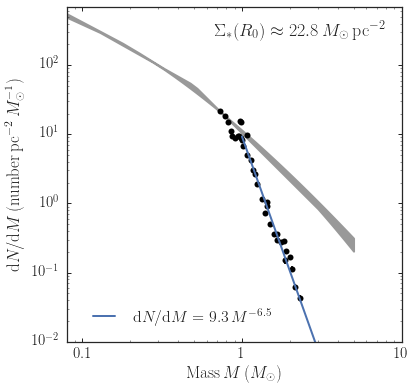

In [21]:
skip= 1
tnpop= 35
dm= sp_massmax[:tnpop:skip]-sp_massmin[skip-1:tnpop+skip-1:skip]
m_mid= sp_mass[:tnpop:skip]
zd= numpy.exp(all_p[:tnpop:skip,1])
zd[m_mid <= 1.]= 0.15 # Because  noisy
surffac= numpy.array([integrate.quad(lambda x: 1./numpy.cosh(x/2000./tzd)**2.,
                                      -1000.,1000.)[0] for tzd in zd])
figsize(6,6)
bovy_plot.bovy_plot(m_mid,
                    numpy.exp(all_p[:tnpop:skip,0]-9.*numpy.log(10.)-numpy.log(dm)+numpy.log(surffac)),
                    'ko',ms=6.,zorder=2,
                    loglog=True,
                    xrange=[0.08,10.],
                    yrange=[0.01,700.],
                   xlabel=r'$\mathrm{Mass}\, M\,(M_\odot)$',
                   ylabel=r'$\mathrm{d} N / \mathrm{d} M\,(\mathrm{number\,pc}^{-2}\,M_\odot^{-1})$')
errorbar(m_mid,
         numpy.exp(all_p[:tnpop:skip,0]-9.*numpy.log(10.)-numpy.log(dm)+numpy.log(surffac)),
         yerr=(numpy.exp(all_s_high[:tnpop:skip,0]-9.*numpy.log(10.)-numpy.log(dm)+numpy.log(surffac))
              -numpy.exp(all_s_low[:tnpop:skip,0]-9.*numpy.log(10.)-numpy.log(dm)+numpy.log(surffac)))/2.,
         marker='None',ls='None',color='k',zorder=1,capsize=0)
ms= numpy.linspace(0.08,5.,101)
imfs= numpy.empty((len(ms),3))
totmass= numpy.empty(3)
for kk,imf_func in enumerate([imf.kroupa2003,imf.lognormalChabrier2001,imf.exponentialChabrier2001]):
    m_indx= numpy.fabs(m_mid-0.75) < 0.05
    fac= numpy.nanmedian((numpy.exp(all_p[:tnpop:skip,0][m_indx]-9.*numpy.log(10.)-numpy.log(dm[m_indx])
                                    +numpy.log(surffac)[m_indx]))\
                         /imf_func(m_mid[m_indx]))
    imfs[:,kk]= imf_func(ms)*fac
    totmass[kk]= (integrate.quad(lambda m: m*imf_func(m)*fac,0.08,1.))[0]
fill_between(ms,numpy.amin(imfs,axis=1),numpy.amax(imfs,axis=1),color='0.6',lw=2.,zorder=0)
# Fit high-mass end
m_high_indx= m_mid > 1.
p= numpy.polyfit(numpy.log(m_mid[m_high_indx]),
                 numpy.log((numpy.exp(all_p[:tnpop:skip,0]-9.*numpy.log(10.)
                                      -numpy.log(dm)+numpy.log(surffac)))[m_high_indx]),
                 w=(numpy.exp(all_p[:tnpop:skip,0]-9.*numpy.log(10.)-numpy.log(dm)))[m_high_indx]\
                 /((numpy.exp(all_s_high[:tnpop:skip,0]-9.*numpy.log(10.)-numpy.log(dm))
              -numpy.exp(all_s_low[:tnpop:skip,0]-9.*numpy.log(10.)-numpy.log(dm)))/2.)[m_high_indx],
                 deg=1)
actual_mass_to8= (integrate.quad(lambda m: m*numpy.exp(numpy.polyval(p,numpy.log(m))),1.,8.))[0]
ms= numpy.linspace(1.,3.,101)
line= plot(ms,numpy.exp(numpy.polyval(p,numpy.log(ms))),color=sns.color_palette()[0],lw=2.)
gcf().legend((line[0],),
              (r'$\mathrm{d} N / \mathrm{d} M = %.1f\,M^{%.1f}$' % (numpy.exp(p[1]),p[0]),),
              bbox_to_anchor=(.66,.225),
              numpoints=8,
              prop={'size':16},
              frameon=False)
bovy_plot.bovy_text(r'$\Sigma_*(R_0) \approx %.1f\,M_\odot\,\mathrm{pc}^{-2}$' \
                    % (numpy.median(totmass)+actual_mass_to8),
                    top_right=True,size=18.)
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))

The shape of the star formation history derived from this is:

('Fit uncertainties, correlation, chi^2/dof, exp. deviation:', array([ 0.1294497,  0.1488692]), -0.97612309343227277, 1.110147849464171, 0.30860669992418382)
('Total amount of mass formed:', 38.568560314442308)
('Total amount of mass formed x 0.6:', 15.427424125776923)


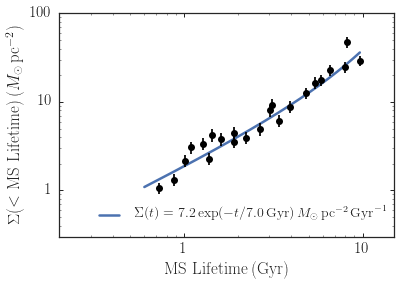

In [22]:
figsize(6,4)
tnpop= 23 # to where we have ages
# Age
def ms_lifetime(m):
    return 10.**(1.015-3.491*numpy.log10(m)+0.8157*numpy.log10(m)**2.)
page= 9.+numpy.log10(ms_lifetime(m_mid))
imfs= numpy.empty((tnpop,3))
for kk,imf_func in enumerate([imf.kroupa2003,imf.lognormalChabrier2001,imf.exponentialChabrier2001]):
    for jj in range(tnpop):
        fac= (numpy.exp(all_p[:tnpop:skip,0]-9.*numpy.log(10.)-numpy.log(dm[:tnpop:skip])))[jj]/imf_func(m_mid[jj])\
                            
        imfs[jj,kk]= (integrate.quad(lambda m: m*imf_func(m)*fac,0.08,100.))[0]\
                        *integrate.quad(lambda x: 1./numpy.cosh(x/2000./numpy.exp(all_p[:tnpop:skip,1][jj]))**2.,
                                       -1000.,1000.)[0]
downfac= 0.9
bovy_plot.bovy_plot(10.**(page-9.)[:tnpop],numpy.median(imfs,axis=1),#/numpy.median(imfs,axis=1)[-1]/downfac,
                    'ko',
                    loglog=True,
                    xrange=[0.2,15.],
#                    yrange=[0.01,2.],
                    yrange=[0.3,100.],
                    xlabel=r'$\mathrm{MS\ Lifetime}\,(\mathrm{Gyr})$',
                    ylabel=r'$\Sigma \mathrm{(< \mathrm{MS\ Lifetime})}\,(M_{\odot}\,\mathrm{pc}^{-2})$')
yerr= 0.5*(numpy.nanmax(imfs,axis=1)-numpy.nanmin(imfs,axis=1))
errorbar(10.**(page-9.)[:tnpop],numpy.median(imfs,axis=1),
         yerr=yerr,marker='None',ls='None',color='k',zorder=1,capsize=0)
Ags= numpy.linspace(0.6,10.**(page-9.)[:tnpop][-1],1001)
#bovy_plot.bovy_plot(Ags,Ags/Ags[-1]*36.,color='0.5',lw=2.5,zorder=0,overplot=True)
def exp_sfh(a,p0,p1):
    return numpy.exp(p1+p0)*(numpy.exp((a-10.)/numpy.exp(p0))-numpy.exp(-10./numpy.exp(p0)))
p,pc= optimize.curve_fit(exp_sfh,10.**(page-9.)[:tnpop],imfs[:,2],#numpy.median(imfs,axis=1),
                         p0=[numpy.log(20.),numpy.log(7.)],
                         sigma=yerr,absolute_sigma=True)
print("Fit uncertainties, correlation, chi^2/dof, exp. deviation:",
      np.sqrt(np.diag(pc)),pc[0,1]/numpy.prod(np.sqrt(np.diag(pc))),
      0.5*numpy.sum((exp_sfh(10.**(page-9.)[:tnpop],p[0],p[1])-numpy.median(imfs,axis=1))**2./yerr**2.)/(tnpop-2.),
     numpy.sqrt(2.*(tnpop-2.))/(tnpop-2.))
print("Total amount of mass formed:",exp_sfh(10.,p[0],p[1]))
print("Total amount of mass formed x 0.6:",exp_sfh(10.,p[0],p[1])*0.4)
line= bovy_plot.bovy_plot(Ags,exp_sfh(Ags,p[0],p[1]),
                          color=sns.color_palette()[0],lw=2.5,ls='-',zorder=0,overplot=True)
gcf().legend((line[0],),
              (r'$\Sigma(t) = %.1f\exp(-t/%.1f\,\mathrm{Gyr})\,M_\odot\,\mathrm{pc}^{-2}\,\mathrm{Gyr}^{-1}$' \
                   % (numpy.exp(p[1]),numpy.exp(p[0])),),
              bbox_to_anchor=(.925,.32),
              numpoints=8,
              prop={'size':14},
              frameon=False)
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','sfh.pdf'),
                bbox_inches='tight')

The scale height acts as:

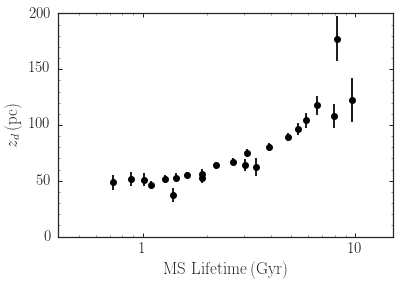

In [23]:
figsize(6,4)
tnpop= 23 # to where we get lower lims and where we have ages
lage_mid= sp_lage[:tnpop:skip]
dlage= numpy.roll(lage_mid,-1)-lage_mid
page= lage_mid-0.5*dlage
page[-1]= lage_mid[-1]+dlage[-3]*0.5
page= 9.+numpy.log10(ms_lifetime(m_mid))
bovy_plot.bovy_plot(10.**(page-9.)[:tnpop],
                    1000.*numpy.exp(all_p[:tnpop:skip,1]),
                    'ko',semilogx=True,
                    xrange=[0.400,15.],
                    yrange=[0.,200.],
                    xlabel=r'$\mathrm{MS\ Lifetime}\,(\mathrm{Gyr})$',
                    ylabel=r'$z_d\,(\mathrm{pc})$')
errorbar(10.**(page-9.)[:tnpop],
         1000.*numpy.exp(all_p[:tnpop:skip,1]),
        yerr=1000.*0.5*(numpy.exp(all_s_high[:tnpop:skip,1])-numpy.exp(all_s_low[:tnpop:skip,1])),
        marker='None',ls='None',capsize=0,color='k')
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','zd.pdf'),
                bbox_inches='tight')

The Sun's displacement from the mid-plane is:

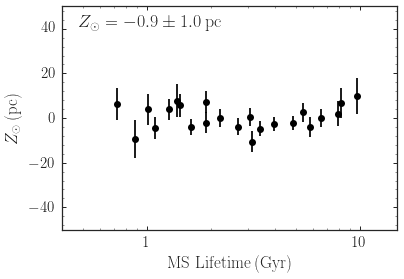

In [24]:
tnpop= 23
figsize(6,4)
bovy_plot.bovy_plot(10.**(page-9.)[:tnpop],
                    1000.*all_p[:tnpop:skip,2],
                    'ko',semilogx=True,
                    xrange=[0.400,15.],
                    yrange=[-50.,50.],
                    xlabel=r'$\mathrm{MS\ Lifetime}\,(\mathrm{Gyr})$',
                    ylabel=r'$Z_\odot\,(\mathrm{pc})$')
yerr= 1000.*0.5*((all_s_high[:tnpop:skip,2])-(all_s_low[:tnpop:skip,2]))
errorbar(10.**(page-9.)[:tnpop],
         1000.*(all_p[:tnpop:skip,2]),
        yerr=yerr,
        marker='None',ls='None',capsize=0,color='k')
zsun_med= numpy.nanmedian(all_s_med[:tnpop,2])*1000.
zsun_mad= numpy.nanmedian(numpy.fabs(1000.*all_s_med[:tnpop,2]-zsun_med))/1.4826
zsun_mean= numpy.sum(1000.*all_p[:tnpop:skip,2]/yerr**2.)/numpy.sum(1./yerr**2.)
zsun_std= numpy.sqrt(1./numpy.sum(1./yerr**2.))
bovy_plot.bovy_text(r'$Z_\odot = %.1f \pm %.1f\,\mathrm{pc}$' % (zsun_mean,zsun_std),
                   top_left=True,size=18.)
#print(zsun_med,zsun_mad,zsun_mean,zsun_std)
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','zsun_fine.pdf'),
                bbox_inches='tight')

Write a table with the results:

In [25]:
skip= 1
tnpop= 35
table= [sp_type[1:tnpop+1:skip],
        sp_jk[1:tnpop+1:skip],
        sp_mv[1:tnpop+1:skip],
        sp_mj[1:tnpop+1:skip],
        sp_mass[1:tnpop+1:skip],        
        numpy.exp(all_p[:tnpop:skip,0]-5.*numpy.log(10.)),
        (numpy.exp(all_s_high[:tnpop:skip,0]-5.*numpy.log(10.))
              -numpy.exp(all_s_low[:tnpop:skip,0]-5.*numpy.log(10.)))/2.,
        numpy.exp(all_p[:tnpop:skip,0]-5.*numpy.log(10.)-numpy.log(dmj)),
        (numpy.exp(all_s_high[:tnpop:skip,0]-5.*numpy.log(10.)-numpy.log(dmj))
              -numpy.exp(all_s_low[:tnpop:skip,0]-5.*numpy.log(10.)-numpy.log(dmj)))/2.,
        numpy.exp(all_p[:tnpop:skip,0]-5.*numpy.log(10.)-numpy.log(dm)),
        (numpy.exp(all_s_high[:tnpop:skip,0]-5.*numpy.log(10.)-numpy.log(dm))
              -numpy.exp(all_s_low[:tnpop:skip,0]-5.*numpy.log(10.)-numpy.log(dm)))/2.,
        numpy.cumsum(numpy.exp(all_p[:tnpop:skip,0]-5.*numpy.log(10.))*sp_mass[1:tnpop+1:skip]),
        1000.*numpy.exp(all_p[:tnpop:skip,1]),
        1000.*0.5*(numpy.exp(all_s_high[:tnpop:skip,1])-numpy.exp(all_s_low[:tnpop:skip,1]))]
table= Table(table,masked=True,
             names=['Spectral type','$J-K_s$','$M_V$','$M_J$','Mass',
                    '$n$','$\sigma(n)$',
                    '$\mathrm{d} n / \mathrm{d} M_V$','$\sigma(\mathrm{d} n / \mathrm{d} M_V)$',
                    '$\mathrm{d} n / \mathrm{d} M$','$\sigma(\mathrm{d} n / \mathrm{d} M)$',
                    '$\rho(>M)$',
                    '$z_d$','$\sigma(z_d)$'])
table['$z_d$'].mask[24:]= True
table['$\sigma(z_d)$'].mask[24:]= True
table['$J-K_s$'].format= "{:.3f}"
table['$M_V$'].format= "{:.2f}"
table['$M_J$'].format= "{:.2f}"
table['Mass'].format= "{:.2f}"
table['$n$'].format= "{:.2f}"
table['$\sigma(n)$'].format= "{:.2f}"
table['$\mathrm{d} n / \mathrm{d} M_V$'].format= "{:.1f}"
table['$\sigma(\mathrm{d} n / \mathrm{d} M_V)$'].format= "{:.1f}"
table['$\mathrm{d} n / \mathrm{d} M$'].format= "{:.1f}"
table['$\sigma(\mathrm{d} n / \mathrm{d} M)$'].format= "{:.1f}"
table['$\rho(>M)$'].format= "{:.1f}"
table['$z_d$'].format= "{:.0f}"
table['$\sigma(z_d)$'].format= "{:.0f}"
if save_tables:
    ascii.write(table,
                os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','mainsequence_results_raw.dat'),
                Writer=ascii.Latex,
                latexdict = {'tabletype': 'table*',
                             'units': {'Mass':'$M_\odot$',
                                       '$n$':'$(10^{-4}\,\mathrm{pc}^{-3})$',
                                        '$\mathrm{d} n / \mathrm{d} M_V$':'$(10^{-4}\,\mathrm{pc}^{-3}\,\mathrm{mag}^{-1})$',
                                        '$\mathrm{d} n / \mathrm{d} M$':'$(10^{-4}\,\mathrm{pc}^{-3}\,M_\odot^{-1})$',
                                        '$z_d$':'(pc)'},
                            'col_align':'cccccr@{$\pm$}lr@{$\pm$}lr@{$\pm$}lcr@{$\pm$}l',
                            'header_end': '\\hline\\hline',
                            'header_start': '\\hline \\hline',
                            'data_end': '\\hline',
                            'caption':'Properties, luminosity function, and mass function of stars along the main-sequence.'})
    # replace some lines
    with open(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','mainsequence_results_raw.dat'),'r') as old_file:
        with open(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','mainsequence_results.dat'),'w') as new_file:
            for line in old_file:
                if line.startswith('Spectral type'):
                    line= 'Spectral type & $J-K_s$ & $M_V$ & $M_J$ & Mass & \multicolumn{2}{c}{$n$} & \multicolumn{2}{c}{$\mathrm{d} n / \mathrm{d} M_V$} & \multicolumn{2}{c}{$\mathrm{d} n / \mathrm{d} M$}& $ \\rho(>M)$& \multicolumn{2}{c}{$z_d$}   \\\\'
                elif line.startswith(' &  &  &  & $M_\odot$ & $(10^{-4}'):
                    line= ' &  &  &  & $M_\odot$ & \multicolumn{2}{c}{$(10^{-4}\,\mathrm{pc}^{-3})$} & \multicolumn{2}{c}{$(10^{-4}\,\mathrm{pc}^{-3}\,\mathrm{mag}^{-1})$}  & \multicolumn{2}{c}{$(10^{-4}\,\mathrm{pc}^{-3}\,M_\odot^{-1})$} & $(10^{-4}\,M_\odot\,\mathrm{pc}^{-3})$ & \multicolumn{2}{c}{(pc)}  \\\\'
                new_file.write(line)
    os.remove(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','mainsequence_results_raw.dat'))

Now, let's do number counts for entire stellar populations, to get better statistics for the later types:

In [26]:
zbins= numpy.arange(-0.4125,0.425,0.025)
npop= 40
dpop= 5
savefilename= 'counts_vert_AthroughF_5bins.sav'
def good_maxxy(spt):
    if 'A' in spt: maxxy= 0.25
    elif 'F' in spt: maxxy= 0.2
    elif 'G' in spt: maxxy= 0.15
    elif 'K' in spt: maxxy= 0.1
    elif 'M' in spt: maxxy= 0.025
    return maxxy
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        all_counts= pickle.load(savefile)
        all_counts_unc= pickle.load(savefile)
        all_effvol= pickle.load(savefile)
else:
    all_counts= numpy.empty((npop,len(zbins)-1))
    all_counts_unc= numpy.empty((npop,len(zbins)-1))
    all_effvol= numpy.empty((npop,len(zbins)-1))
    multiOut= multi.parallel_map(\
                lambda x: vertical_counts_onepop(zbins,
                                                 dataXY[(jk > sp_jk_bins[x])*(jk < sp_jk_bins[x+dpop])\
                                                         *(tgas['parallax'] > min_plx)*(jk != 0.)\
                                                         *(mj > main_sequence_cut_r(jk))\
                                                         *(mj < main_sequence_cut_r(jk,low=True))],
                                                 dataZ[(jk > sp_jk_bins[x])*(jk < sp_jk_bins[x+dpop])\
                                                         *(tgas['parallax'] > min_plx)*(jk != 0.)\
                                                         *(mj > main_sequence_cut_r(jk))\
                                                         *(mj < main_sequence_cut_r(jk,low=True))],
                                                 jk[(jk > sp_jk_bins[x])*(jk < sp_jk_bins[x+dpop])\
                                                    *(tgas['parallax']/tgas['parallax_error'] > (good_relplx(mj)))\
                                                    *(jk != 0.)],
                                                 mj[(jk > sp_jk_bins[x])*(jk < sp_jk_bins[x+dpop])\
                                                    *(tgas['parallax']/tgas['parallax_error'] > (good_relplx(mj)))\
                                                    *(jk != 0.)],
                                                 sp['SpT'][sp_indx][x],
                                                 maxxy=good_maxxy(sp['SpT'][sp_indx][x])),
                                range(npop),numcores=30)
    for ii in range(npop):
        all_counts[ii]= multiOut[ii][0]
        all_counts_unc[ii]= multiOut[ii][1]
        all_effvol[ii]= multiOut[ii][2]
    save_pickles(savefilename,all_counts,all_counts_unc,all_effvol)

In [27]:
nsamples= 10000
all_p= numpy.empty((npop,5))
all_s= numpy.empty((npop,5,nsamples))
all_s_med= numpy.empty((npop,5))
all_s_mad= numpy.empty((npop,5))
all_s_low= numpy.empty((npop,5))
all_s_high= numpy.empty((npop,5))
all_s_vlow= numpy.empty((npop,5))
all_s_vhigh= numpy.empty((npop,5))
for ii in tqdm.tqdm(range(npop)):
    c= all_counts[ii]
    ec= all_counts_unc[ii]
    raw= c*all_effvol[ii]
    ef= all_effvol[ii]/(good_maxxy(sp['SpT'][sp_indx][ii])**2.*numpy.pi*(zbins[1]-zbins[0]))
    all_p[ii]= fit_sech2(c,ec,ef,raw,zbins,verbose=False,include_outlier=True)
    ts= sample_sech2(c,ec,ef,raw,zbins,verbose=False,include_outlier=True,nsamples=nsamples)
    if len(ts.shape) == 1:
        all_s[ii,:,:]= numpy.nan
        all_s_med[ii,:]= numpy.nan
        all_s_mad[ii,:]= numpy.nan
        all_s_low[ii,:]= numpy.nan
        all_s_high[ii,:]= numpy.nan
    else:
        all_s[ii]= ts
        all_s_med[ii]= numpy.nanmedian(ts,axis=1)
        all_s_mad[ii]= numpy.nanmedian(numpy.fabs(ts.T-all_s_med[ii]).T,axis=1)
        for jj in range(len(all_s[ii])):
            all_s_low[ii,jj]= all_s[ii,jj,numpy.argsort(all_s[ii,jj])][int(numpy.floor(0.16*nsamples))]
            all_s_high[ii,jj]= all_s[ii,jj,numpy.argsort(all_s[ii,jj])][int(numpy.floor(0.84*nsamples))]            
            all_s_vlow[ii,jj]= all_s[ii,jj,numpy.argsort(all_s[ii,jj])][int(numpy.floor(0.01*nsamples))]
            all_s_vhigh[ii,jj]= all_s[ii,jj,numpy.argsort(all_s[ii,jj])][int(numpy.floor(0.99*nsamples))]            

The Sun's displacement from the plane for these is consistent with the previous results, even for the early G dwarfs:

In [28]:
zsuns= 1000.*all_p[:npop:dpop,2]
zsuns_err= 1000.*0.5*(all_s_high[:npop:dpop,2]-all_s_low[:npop:dpop,2])
print(zsuns,zsuns_err,
      numpy.sum(zsuns/zsuns_err**2.)/numpy.sum(1./zsuns_err**2.),
      numpy.sqrt(1./numpy.sum(1./zsuns_err**2.)))

(array([  1.62923414,   0.7766255 ,  -4.02790839,  -1.36881916,
         7.28741742,  49.99889135, -28.98119376, -50.        ]), array([  2.45018464,   2.11333319,   2.01391567,   2.00779021,
         4.35334403,  15.79867752,  11.6608912 ,  42.79518822]), -0.57169385212679158, 1.0261021585336192)


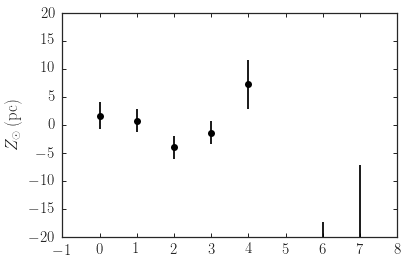

In [29]:
figsize(6,4)
errorbar(numpy.arange(len(zsuns)),zsuns,yerr=zsuns_err,ls='None',color='k',marker='o')
ylim(-20.,20.)
xlim(-1.,8.)
ylabel(r'$Z_\odot\,(\mathrm{pc})$')

Let's now see whether extinction plays a large role. For this, we fit entire spectral types, because we have pre-computed the effective selection function in the presence of extinction for those. The following is the density of the five stellar types (from top to bottom: A, F, G, K, and M):

In [30]:
zbins= numpy.arange(-0.4125,0.425,0.025)
SpTypes= ['A','F','G','K','M']
npop= len(SpTypes)
savefilename= 'counts_vert_AthroughF_10bins_wext.sav'
if False:
    tesf_savefilename_base= '/geir_data/scr/bovy/tgas-completeness/tgEffsel'
else:
    tesf_savefilename_base= 'tgEffsel'
tesf= gaia_tools.select.tgasEffectiveSelect(tsf,dmap3d=mwdust.Zero(),maxd=max_dist)
def good_maxxy(spt):
    if 'A' in spt: maxxy= 0.25
    elif 'F' in spt: maxxy= 0.2
    elif 'G' in spt: maxxy= 0.15
    elif 'K' in spt: maxxy= 0.1
    elif 'M' in spt: maxxy= 0.025
    return maxxy
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        all_counts= pickle.load(savefile)
        all_counts_unc= pickle.load(savefile)
        all_effvol= pickle.load(savefile)
else:
    all_counts= numpy.empty((npop,len(zbins)-1,2))
    all_counts_unc= numpy.empty((npop,len(zbins)-1,2))
    all_effvol= numpy.empty((npop,len(zbins)-1,2))
    for ii,sptype in enumerate(SpTypes):
        print(sptype)
        t_tesf_savefilename= tesf_savefilename_base+'_%s.sav' % sptype
        if os.path.exists(t_tesf_savefilename):
            with open(t_tesf_savefilename,'rb') as savefile:
                tesf_ext= pickle.load(savefile)
            MJ= tesf_ext._MJ
            JK= tesf_ext._JK
        else:
            raise IOError("Effective selection savefile %s does not exist ...")
        tesf._MJ= MJ
        tesf._JK= JK
        evfs= numpy.empty((len(zbins)-1,2))
        ndists=2501*('A' in sptype) + 1001 * (True-('A' in sptype))
        for jj in tqdm.tqdm(range(len(zbins)-1)):
            evfs[jj,0]= tesf.volume(lambda x,y,z: cyl_vol_func(x,y,z,xymax=good_maxxy(sptype),
                                                               zmin=zbins[jj],zmax=zbins[jj+1]),
                                    ndists=ndists,xyz=True,relative=True)
            evfs[jj,1]= tesf_ext.volume(lambda x,y,z: cyl_vol_func(x,y,z,xymax=good_maxxy(sptype),
                                                                   zmin=zbins[jj],zmax=zbins[jj+1]),
                                        ndists=ndists,xyz=True,relative=True)
        evfs[:,0]*= numpy.pi*good_maxxy(sptype)**2.*(numpy.roll(zbins,-1)-zbins)[:-1]
        evfs[:,1]*= numpy.pi*good_maxxy(sptype)**2.*(numpy.roll(zbins,-1)-zbins)[:-1]
        jkmin= (sp['JH']+sp['HK'])[sp['SpT']=='%s0V' % sptype]
        if sptype == 'M':
            jkmax= (sp['JH']+sp['HK'])[sp['SpT']=='%s5V' % sptype]
        else:
            jkmax= (sp['JH']+sp['HK'])[sp['SpT']=='%s9V' % sptype]
        jmin= main_sequence_cut_r(jkmax)
        jmax= main_sequence_cut_r(jkmin)
        xy_data= dataXY[(jk > jkmin)*(jk < jkmax)\
                         *(tgas['parallax'] > min_plx)*(jk != 0.)\
                         *(mj > main_sequence_cut_r(jk))\
                         *(mj < main_sequence_cut_r(jk,low=True))]
        z_data= dataZ[(jk > jkmin)*(jk < jkmax)\
                      *(tgas['parallax'] > min_plx)*(jk != 0.)\
                      *(mj > main_sequence_cut_r(jk))\
                      *(mj < main_sequence_cut_r(jk,low=True))]
        counts, _= numpy.histogram(z_data[xy_data < good_maxxy(sptype)],bins=zbins)
        all_counts[ii,:,0]= counts/evfs[:,0]
        all_counts[ii,:,1]= counts/evfs[:,1]  
        all_counts_unc[ii,:,0]= numpy.sqrt(counts)/evfs[:,0]
        all_counts_unc[ii,:,1]= numpy.sqrt(counts)/evfs[:,1]        
        all_effvol[ii]= evfs
    save_pickles(savefilename,all_counts,all_counts_unc,all_effvol)

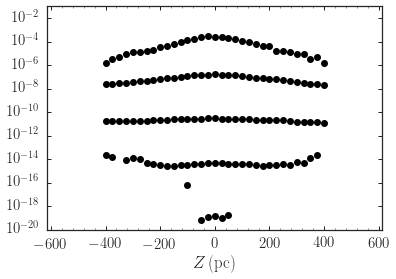

In [31]:
for ii in range(5):
    bovy_plot.bovy_plot(1000.*0.5*(numpy.roll(zbins,-1)+zbins)[:-1],
                        all_counts[ii,:,0]/10.**9./10.**(ii*4),
                        'ko',gcf=True,overplot=ii>0,
                        yrange=[10.**-20.,10.**-1.],
                        semilogy=True,
                        xrange=[1000.*(zbins[0]-0.2),1000.*(zbins[-1]+0.2)],
                        zorder=2,
                        xlabel=r'$Z\,(\mathrm{pc})$')

The relative difference for these between using extinction and not using extinction:

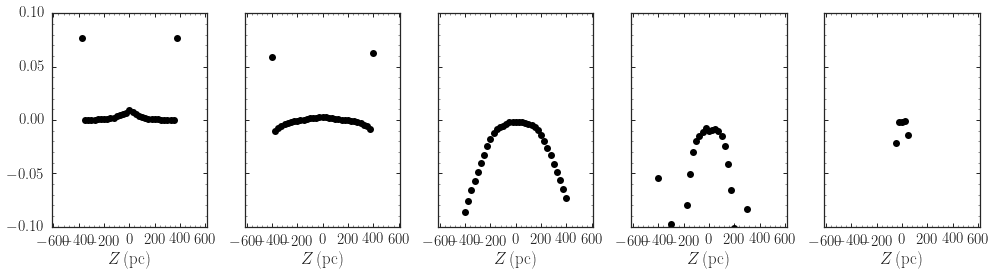

In [32]:
figsize(14,4)
for ii in range(5):
    subplot(1,5,ii+1)
    bovy_plot.bovy_plot(1000.*0.5*(numpy.roll(zbins,-1)+zbins)[:-1],
                        (all_counts[ii,:,0]-all_counts[ii,:,1])/all_counts[ii,:,0],
                        'ko',gcf=True,
                        yrange=[-.1,.1],
                        semilogy=False,
                        xrange=[1000.*(zbins[0]-0.2),1000.*(zbins[-1]+0.2)],
                        zorder=2,
                        xlabel=r'$Z\,(\mathrm{pc})$')
    if ii > 0:
        gca().yaxis.set_major_formatter(NullFormatter())
tight_layout()

The fits for all parameters are also consistent to within their uncertainties for counts that include and exclude the effect of extinction. In particular, the mid-plane density changes by $\lesssim1\%$, the scale height by $\approx 1$ pc for A and F (and only a few pc for other types), and the Sun's height above the midplane by only about 0.1 pc for A and F stars and 1 pc for G stars (unconstrained for K and M):

In [33]:
all_fit= numpy.empty((5,5,2))
nsamples= 10000
all_sample= numpy.empty((5,5,2,nsamples))
for ii in range(5):
    all_fit[ii,:,0]= fit_sech2(all_counts[ii,:,0],all_counts_unc[ii,:,0],all_effvol[ii,:,0],all_counts[ii,:,0]*all_effvol[ii,:,0],
                             zbins,verbose=False,include_outlier=True)
    all_sample[ii,:,0,:]= sample_sech2(all_counts[ii,:,0],all_counts_unc[ii,:,0],all_effvol[ii,:,0],all_counts[ii,:,0]*all_effvol[ii,:,0],
                             zbins,verbose=False,include_outlier=True,nsamples=nsamples)
    all_fit[ii,:,1]= fit_sech2(all_counts[ii,:,1],all_counts_unc[ii,:,1],all_effvol[ii,:,1],all_counts[ii,:,1]*all_effvol[ii,:,1],
                             zbins,verbose=False,include_outlier=True)
    all_sample[ii,:,1,:]= sample_sech2(all_counts[ii,:,1],all_counts_unc[ii,:,1],all_effvol[ii,:,1],all_counts[ii,:,1]*all_effvol[ii,:,1],
                             zbins,verbose=False,include_outlier=True,nsamples=nsamples)

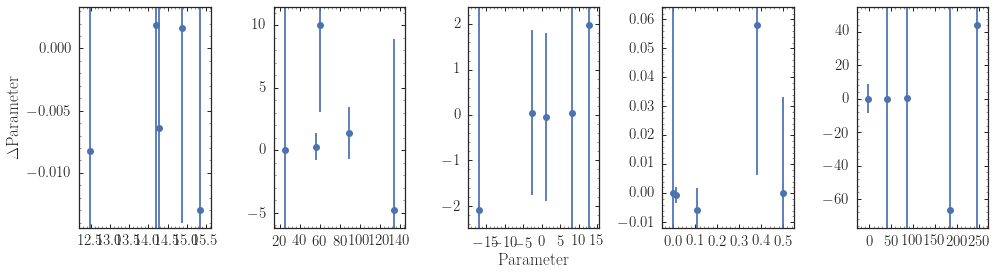

In [34]:
figsize(14,4)
funcs= [lambda x: x, lambda x: numpy.exp(x)*1000.,lambda x: 1000.*x,lambda x: x, lambda x: x]
for ii,func in enumerate(funcs):
    subplot(1,5,ii+1)
    tx= func(all_fit[:,ii,0])
    ty= func(all_fit[:,ii,1])-func(all_fit[:,ii,0])
    tyerr= numpy.empty_like(ty)
    for jj in range(5):
        tyerr[jj]=\
            func(all_sample[jj,ii,0,numpy.argsort(all_sample[jj,ii,0])][int(numpy.floor(0.84*nsamples))])\
            -func(all_sample[jj,ii,0,numpy.argsort(all_sample[jj,ii,0])][int(numpy.floor(0.16*nsamples))])
    tyerr/= 2.
    if ii == 2:
        txlabel= r'$\mathrm{Parameter}$'
    else:
        txlabel= None
    if ii == 0:
        tylabel= r'$\Delta \mathrm{Parameter}$'
    else:
        tylabel= None
    bovy_plot.bovy_plot(tx,ty,'o',gcf=True,
                       xrange=[numpy.amin(tx)-0.1*(numpy.amax(tx)-numpy.amin(tx)),
                               numpy.amax(tx)+0.1*(numpy.amax(tx)-numpy.amin(tx))],
                       yrange=[numpy.amin(ty)-0.1*(numpy.amax(ty)-numpy.amin(ty)),
                               numpy.amax(ty)+0.1*(numpy.amax(ty)-numpy.amin(ty))],
                       xlabel=txlabel,ylabel=tylabel)
    errorbar(tx,ty,yerr=tyerr,marker='None',ls='None',capsize=0.,color=sns.color_palette()[0])
tight_layout()

Now, let's investigate whether the bright end of the raw *TGAS* selection function plays any role, because we trust the bright end less than the faint end because of how we determined the *TGAS* selection function. The density profiles are similar, except that those of the earliest (brightest) types get to be very noisy:

In [35]:
zbins= numpy.arange(-0.4125,0.425,0.025)
npop= 45
dpop= 1
savefilename= 'counts_vert_AthroughF_singlebins_cutbright.sav' 
def good_maxxy(spt):
    if 'A' in spt: maxxy= 0.25
    elif 'F' in spt: maxxy= 0.2
    elif 'G' in spt: maxxy= 0.15
    elif 'K' in spt: maxxy= 0.1
    elif 'M' in spt: maxxy= 0.025
    return maxxy
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        all_counts= pickle.load(savefile)
        all_counts_unc= pickle.load(savefile)
        all_effvol= pickle.load(savefile)
else:
    all_counts= numpy.empty((npop,len(zbins)-1))
    all_counts_unc= numpy.empty((npop,len(zbins)-1))
    all_effvol= numpy.empty((npop,len(zbins)-1))
    multiOut= multi.parallel_map(\
                lambda x: vertical_counts_onepop(zbins,
                                                 dataXY[(jk > sp_jk_bins[x])*(jk < sp_jk_bins[x+dpop])\
                                                         *(twomass['j_mag'] > 8.
                                                               -((0.5*(sp_jk_bins[x]+sp_jk_bins[x+dpop]))**2.
                                                               +2.5*(0.5*(sp_jk_bins[x]+sp_jk_bins[x+dpop]))))\
                                                         *(tgas['parallax'] > min_plx)*(jk != 0.)\
                                                         *(mj > main_sequence_cut_r(jk))\
                                                         *(mj < main_sequence_cut_r(jk,low=True))],
                                                 dataZ[(jk > sp_jk_bins[x])*(jk < sp_jk_bins[x+dpop])\
                                                         *(twomass['j_mag'] > 8.
                                                               -((0.5*(sp_jk_bins[x]+sp_jk_bins[x+dpop]))**2.
                                                               +2.5*(0.5*(sp_jk_bins[x]+sp_jk_bins[x+dpop]))))\
                                                         *(tgas['parallax'] > min_plx)*(jk != 0.)\
                                                         *(mj > main_sequence_cut_r(jk))\
                                                         *(mj < main_sequence_cut_r(jk,low=True))],
                                                 jk[(jk > sp_jk_bins[x])*(jk < sp_jk_bins[x+dpop])\
                                                    *(tgas['parallax']/tgas['parallax_error'] > (good_relplx(mj)))\
                                                    *(jk != 0.)],
                                                 mj[(jk > sp_jk_bins[x])*(jk < sp_jk_bins[x+dpop])\
                                                    *(tgas['parallax']/tgas['parallax_error'] > (good_relplx(mj)))\
                                                    *(jk != 0.)],
                                                 sp['SpT'][sp_indx][x],
                                                 maxxy=good_maxxy(sp['SpT'][sp_indx][x]),cutbright=True),
                                range(npop),numcores=30)
    for ii in range(npop):
        all_counts[ii]= multiOut[ii][0]
        all_counts_unc[ii]= multiOut[ii][1]
        all_effvol[ii]= multiOut[ii][2]
    save_pickles(savefilename,all_counts,all_counts_unc,all_effvol)

In [36]:
nsamples= 10000
all_p_cb= numpy.empty((npop,5))
all_s_cb= numpy.empty((npop,5,nsamples))
all_s_med_cb= numpy.empty((npop,5))
all_s_mad_cb= numpy.empty((npop,5))
all_s_low_cb= numpy.empty((npop,5))
all_s_high_cb= numpy.empty((npop,5))
all_s_vlow_cb= numpy.empty((npop,5))
all_s_vhigh_cb= numpy.empty((npop,5))
for ii in tqdm.tqdm(range(npop)):
    c= all_counts[ii]
    ec= all_counts_unc[ii]
    raw= c*all_effvol[ii]
    ef= all_effvol[ii]/(good_maxxy(sp['SpT'][sp_indx][ii])**2.*numpy.pi*(zbins[1]-zbins[0]))
    all_p_cb[ii]= fit_sech2(c,ec,ef,raw,zbins,verbose=False,include_outlier=True)
    ts= sample_sech2(c,ec,ef,raw,zbins,verbose=False,include_outlier=True,nsamples=nsamples)
    if len(ts.shape) == 1:
        all_s_cb[ii,:,:]= numpy.nan
        all_s_med_cb[ii,:]= numpy.nan
        all_s_mad_cb[ii,:]= numpy.nan
        all_s_low_cb[ii,:]= numpy.nan
        all_s_high_cb[ii,:]= numpy.nan
    else:
        all_s_cb[ii]= ts
        all_s_med_cb[ii]= numpy.nanmedian(ts,axis=1)
        all_s_mad_cb[ii]= numpy.nanmedian(numpy.fabs(ts.T-all_s_med_cb[ii]).T,axis=1)
        for jj in range(len(all_s_cb[ii])):
            all_s_low_cb[ii,jj]= all_s_cb[ii,jj,numpy.argsort(all_s_cb[ii,jj])][int(numpy.floor(0.16*nsamples))]
            all_s_high_cb[ii,jj]= all_s_cb[ii,jj,numpy.argsort(all_s_cb[ii,jj])][int(numpy.floor(0.84*nsamples))]            
            all_s_vlow_cb[ii,jj]= all_s_cb[ii,jj,numpy.argsort(all_s_cb[ii,jj])][int(numpy.floor(0.01*nsamples))]
            all_s_vhigh_cb[ii,jj]= all_s_cb[ii,jj,numpy.argsort(all_s_cb[ii,jj])][int(numpy.floor(0.99*nsamples))]            

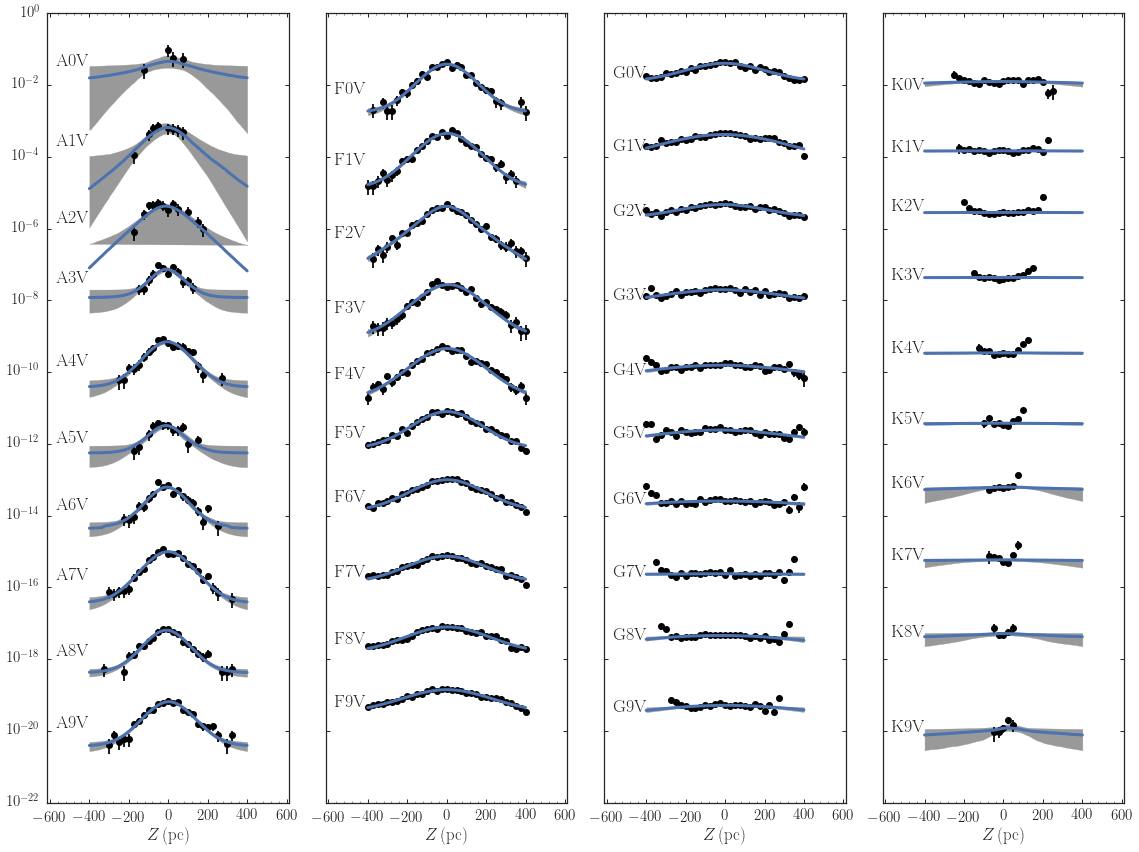

In [37]:
figsize(16,12)
npop_plot= 40
dii= dpop
zs= numpy.linspace(-0.4,0.4,101)
include_range= True
for ii in tqdm.tqdm(range(npop_plot)):
    c= all_counts[ii]
    ec= all_counts_unc[ii]
    raw= c*all_effvol[ii]
    ef= all_effvol[ii]/(good_maxxy(sp['SpT'][sp_indx][ii])**2.*numpy.pi*(zbins[1]-zbins[0]))
    good_dens_indx= (ef > sf_unc*numpy.nanmax(ef))*(c > 0.)*((ef == ef[len(ef)//2])+(ef > 10.**-5.))*(raw > 4.)
    subplot(1,4,ii//10+1)
    bovy_plot.bovy_plot(1000.*0.5*(numpy.roll(zbins,-1)+zbins)[:-1][good_dens_indx],
                        c[good_dens_indx]/10.**6./10**(2.*(ii%10))/10**((ii//10)/2.),
                        'ko',gcf=True,overplot=(ii%10 > 0),
                        yrange=[10.**-22.,10.**0.],
                        semilogy=True,
                        xrange=[1000.*(zbins[0]-0.2),1000.*(zbins[-1]+0.2)],
                        zorder=2,
                        xlabel=r'$Z\,(\mathrm{pc})$')
    errorbar(1000.*0.5*(numpy.roll(zbins,-1)+zbins)[:-1][good_dens_indx],
             c[good_dens_indx]/10.**6./10**(2.*(ii%10))/10**((ii//10)/2.),
             ec[good_dens_indx]/10.**6./10**(2.*(ii%10))/10**((ii//10)/2.),
             marker='None',ls='None',color='k',capsize=0,zorder=1)
    if include_range:
        s= sample_sech2(c,ec,ef,raw,zbins,include_outlier=True,plots=False,nsamples=10000,verbose=False)
        all_prof= sech2profile(numpy.tile(zs,(10000,1)),
                               numpy.tile(s.T,(len(zs),1,1)).T)/10.**6./10**(2.*(ii%10))/10**((ii//10)/2.)
        all_prof= numpy.sort(all_prof,axis=0)
        plot(1000.*zs,all_prof[int(numpy.floor(0.5*len(all_prof)))],color=sns.color_palette()[0],lw=3.)
        fill_between(1000.*zs,
                     all_prof[int(numpy.floor(0.16*len(all_prof)))],all_prof[int(numpy.floor(0.84*len(all_prof)))],
                    color='0.6',zorder=0)
    else:
        p= fit_sech2(c,ec,ef,raw,zbins,include_outlier=True,verbose=False)
        plot(1000.*zs,sech2profile(zs,p)/10.**6./10**(2.*(ii%10))/10**((ii//10)/2.),lw=3.,color=sns.color_palette()[0])
    if ii/10 > 0:
        gca().yaxis.set_major_formatter(NullFormatter())
    bovy_plot.bovy_text(-570.,
                        numpy.exp(0.5*(numpy.log(numpy.nanmax(c[good_dens_indx]))
                                       +numpy.log(numpy.nanmin(c[good_dens_indx]))))\
                            /10.**6./10**(2.*(ii%10))/10**((ii//10)/2.)/1.5,
                        r'$\mathrm{%s}$' % (sp['SpT'][sp_indx][ii]),size=18.)
tight_layout()

The derived mass function is almost exactly the same:

MF at 1 Msun = 0.0420, to be compared with Chabrier's 0.0443
('Expected mass in white dwarfs coming from 1 to 8 Msun <', 0.003514383039282123)


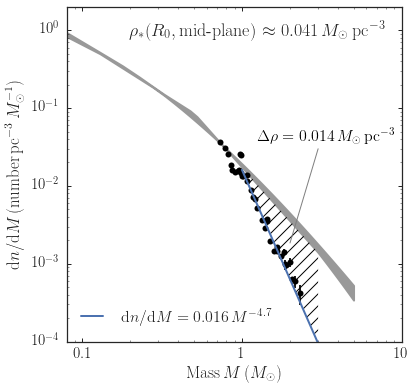

In [38]:
skip= 1
tnpop= 35
dm= sp_massmax[:tnpop:skip]-sp_massmin[skip-1:tnpop+skip-1:skip]
m_mid= sp_mass[:tnpop:skip]
figsize(6,6)
bovy_plot.bovy_plot(m_mid,
                    numpy.exp(all_p_cb[:tnpop:skip,0]-9.*numpy.log(10.)-numpy.log(dm)),
                    'ko',ms=6.,zorder=2,
                    loglog=True,
                    xrange=[0.08,10.],
                    yrange=[0.0001,2.],
                   xlabel=r'$\mathrm{Mass}\, M\,(M_\odot)$',
                   ylabel=r'$\mathrm{d} n / \mathrm{d} M\,(\mathrm{number\,pc}^{-3}\,M_\odot^{-1})$')
errorbar(m_mid,
         numpy.exp(all_p_cb[:tnpop:skip,0]-9.*numpy.log(10.)-numpy.log(dm)),
         yerr=(numpy.exp(all_s_high_cb[:tnpop:skip,0]-9.*numpy.log(10.)-numpy.log(dm))
              -numpy.exp(all_s_low_cb[:tnpop:skip,0]-9.*numpy.log(10.)-numpy.log(dm)))/2.,
         marker='None',ls='None',color='k',zorder=1,capsize=0)
ms= numpy.linspace(0.08,5.,101)
imfs= numpy.empty((len(ms),3))
totmass= numpy.empty(3)
for kk,imf_func in enumerate([imf.kroupa2003,imf.lognormalChabrier2001,imf.exponentialChabrier2001]):
    m_indx= numpy.fabs(m_mid-0.75) < 0.05
    fac= numpy.nanmedian((numpy.exp(all_p_cb[:tnpop:skip,0][m_indx]-9.*numpy.log(10.)-numpy.log(dm[m_indx])))\
                         /imf_func(m_mid[m_indx]))
    imfs[:,kk]= imf_func(ms)*fac
    totmass[kk]= (integrate.quad(lambda m: m*imf_func(m)*fac,0.08,1.))[0]
fill_between(ms,numpy.amin(imfs,axis=1),numpy.amax(imfs,axis=1),color='0.6',lw=2.,zorder=0)
print("MF at 1 Msun = %.4f, to be compared with Chabrier's 0.0443" \
      % (numpy.median(imfs[numpy.argmin(numpy.fabs(ms-1.))])*numpy.log(10.)))
# Fit high-mass end
m_high_indx= m_mid > 1.
p= numpy.polyfit(numpy.log(m_mid[m_high_indx]),
                 numpy.log((numpy.exp(all_p_cb[:tnpop:skip,0]-9.*numpy.log(10.)-numpy.log(dm)))[m_high_indx]),
                 w=(numpy.exp(all_p_cb[:tnpop:skip,0]-9.*numpy.log(10.)-numpy.log(dm)))[m_high_indx]\
                 /((numpy.exp(all_s_high_cb[:tnpop:skip,0]-9.*numpy.log(10.)-numpy.log(dm))
              -numpy.exp(all_s_low_cb[:tnpop:skip,0]-9.*numpy.log(10.)-numpy.log(dm)))/2.)[m_high_indx],
                 deg=1)
ms= numpy.linspace(1.,3.,101)
line= plot(ms,numpy.exp(numpy.polyval(p,numpy.log(ms))),color=sns.color_palette()[0],lw=2.)
gcf().legend((line[0],),
              (r'$\mathrm{d} n / \mathrm{d} M = %.3f\,M^{%.1f}$' % (numpy.exp(p[1]),p[0]),),
              bbox_to_anchor=(.66,.225),
              numpoints=8,
              prop={'size':16},
              frameon=False)
# Calculate how much mass is missing
expect_mass= (integrate.quad(lambda m: m*imf_func(m)*fac,1.,3.))[0]
actual_mass= (integrate.quad(lambda m: m*numpy.exp(numpy.polyval(p,numpy.log(m))),1.,3.))[0]
expect_mass_wd= (integrate.quad(lambda m: (0.109*m+0.394)*imf_func(m)*fac,1.,8.))[0] # From Kalirai+(2008)
#expect_mass_wd= (integrate.quad(lambda m: (0.106*m+0.409)*imf_func(m)*fac,1.,8.))[0] # From Kalirai+(2008)
# high-mass power-law has to be -6.7 steeper to get 0.006 Msun/pc^3 WD!
actual_mass_to8= (integrate.quad(lambda m: m*numpy.exp(numpy.polyval(p,numpy.log(m))),1.,8.))[0]
print("Expected mass in white dwarfs coming from 1 to 8 Msun <",expect_mass_wd-actual_mass_to8)
missing_mass= expect_mass-actual_mass
# Again compute the IMF
imfs= numpy.empty((len(ms),3))
for kk,imf_func in enumerate([imf.kroupa2003,imf.lognormalChabrier2001,imf.exponentialChabrier2001]):
    m_indx= numpy.fabs(m_mid-0.75) < 0.05
    fac= numpy.nanmedian((numpy.exp(all_p_cb[:tnpop:skip,0][m_indx]-9.*numpy.log(10.)-numpy.log(dm[m_indx])))\
                         /imf_func(m_mid[m_indx]))
    imfs[:,kk]= imf_func(ms)*fac
fill_between(ms,numpy.exp(numpy.polyval(p,numpy.log(ms))),numpy.amin(imfs,axis=1),hatch='//',
             color="none",edgecolor="k",linewidth=0.0)
plot((2.,3.),(1.85*10.**-3.,3.*10.**-2.),'-',color='0.5',lw=1.)
bovy_plot.bovy_text(1.25,3.5*10.**-2.,r'$\Delta \rho = %.3f\,M_\odot\,\mathrm{pc}^{-3}$' % missing_mass,
                   size=16.,color='k')
bovy_plot.bovy_text(r'$\rho_*(R_0,\mathrm{mid\hbox{-}plane}) \approx %.3f\,M_\odot\,\mathrm{pc}^{-3}$' \
                    % (numpy.median(totmass)+actual_mass_to8),
                    top_right=True,size=18.)
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))

The scale height is:

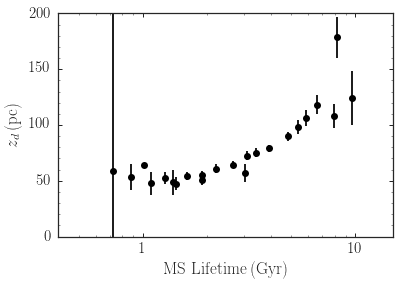

In [39]:
figsize(6,4)
tnpop= 23 # to where we get lower lims and where we have ages
lage_mid= sp_lage[:tnpop:skip]
dlage= numpy.roll(lage_mid,-1)-lage_mid
page= lage_mid-0.5*dlage
page[-1]= lage_mid[-1]+dlage[-3]*0.5
page= 9.+numpy.log10(ms_lifetime(m_mid))
bovy_plot.bovy_plot(10.**(page-9.)[:tnpop],
                    1000.*numpy.exp(all_p_cb[:tnpop:skip,1]),
                    'ko',semilogx=True,
                    xrange=[0.400,15.],
                    yrange=[0.,200.],
                    xlabel=r'$\mathrm{MS\ Lifetime}\,(\mathrm{Gyr})$',
                    ylabel=r'$z_d\,(\mathrm{pc})$')
errorbar(10.**(page-9.)[:tnpop],
         1000.*numpy.exp(all_p_cb[:tnpop:skip,1]),
        yerr=1000.*0.5*(numpy.exp(all_s_high_cb[:tnpop:skip,1])-numpy.exp(all_s_low_cb[:tnpop:skip,1])),
        marker='None',ls='None',capsize=0,color='k')
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))

The Sun's height above the plane in this case is

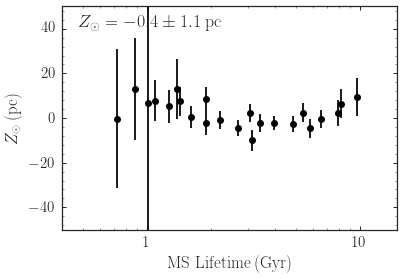

In [40]:
tnpop= 23
skip= 1
m_mid= sp_mass[:tnpop:skip]
page= 9.+numpy.log10(ms_lifetime(m_mid))
figsize(6,4)
bovy_plot.bovy_plot(10.**(page-9.)[:tnpop],
                    1000.*all_p_cb[:tnpop:skip,2],
                    'ko',semilogx=True,
                    xrange=[0.400,15.],
                    yrange=[-50.,50.],
                    xlabel=r'$\mathrm{MS\ Lifetime}\,(\mathrm{Gyr})$',
                    ylabel=r'$Z_\odot\,(\mathrm{pc})$')
yerr= 1000.*0.5*((all_s_high_cb[:tnpop:skip,2])-(all_s_low_cb[:tnpop:skip,2]))
errorbar(10.**(page-9.)[:tnpop],
         1000.*(all_p_cb[:tnpop:skip,2]),
        yerr=yerr,
        marker='None',ls='None',capsize=0,color='k')
zsun_med= numpy.nanmedian(all_s_med_cb[:tnpop,2])*1000.
zsun_mad= numpy.nanmedian(numpy.fabs(1000.*all_s_med_cb[:tnpop,2]-zsun_med))/1.4826
zsun_mean= numpy.sum(1000.*all_p_cb[:tnpop:skip,2]/yerr**2.)/numpy.sum(1./yerr**2.)
zsun_std= numpy.sqrt(1./numpy.sum(1./yerr**2.))
bovy_plot.bovy_text(r'$Z_\odot = %.1f \pm %.1f\,\mathrm{pc}$' % (zsun_mean,zsun_std),
                   top_left=True,size=18.)
#print(zsun_med,zsun_mad,zsun_mean,zsun_std)
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))

Thus, all results are almost exactly the same. The main difference is that the density profiles and parameters for the earliest types (early A) become noisy, because these stars are so bright that most of those that are contained in *TGAS* within a few 100 pc are brighter than the bright cut-off.

As another check, let's look at what we find if we use the same size cylinder for all stellar types, that is, 150 pc:

In [41]:
zbins= numpy.arange(-0.4125,0.425,0.025)
npop= 45
dpop= 1
savefilename= 'counts_vert_AthroughF_singlebins_150pccyl.sav'
def good_maxxy(spt):
    return 0.15
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        all_counts= pickle.load(savefile)
        all_counts_unc= pickle.load(savefile)
        all_effvol= pickle.load(savefile)
else:
    all_counts= numpy.empty((npop,len(zbins)-1))
    all_counts_unc= numpy.empty((npop,len(zbins)-1))
    all_effvol= numpy.empty((npop,len(zbins)-1))
    multiOut= multi.parallel_map(\
                lambda x: vertical_counts_onepop(zbins,
                                                 dataXY[(jk > sp_jk_bins[x])*(jk < sp_jk_bins[x+dpop])\
                                                         *(tgas['parallax'] > min_plx)*(jk != 0.)\
                                                         *(mj > main_sequence_cut_r(jk))\
                                                         *(mj < main_sequence_cut_r(jk,low=True))],
                                                 dataZ[(jk > sp_jk_bins[x])*(jk < sp_jk_bins[x+dpop])\
                                                         *(tgas['parallax'] > min_plx)*(jk != 0.)\
                                                         *(mj > main_sequence_cut_r(jk))\
                                                         *(mj < main_sequence_cut_r(jk,low=True))],
                                                 jk[(jk > sp_jk_bins[x])*(jk < sp_jk_bins[x+dpop])\
                                                    *(tgas['parallax']/tgas['parallax_error'] > (good_relplx(mj)))\
                                                    *(jk != 0.)],
                                                 mj[(jk > sp_jk_bins[x])*(jk < sp_jk_bins[x+dpop])\
                                                    *(tgas['parallax']/tgas['parallax_error'] > (good_relplx(mj)))\
                                                    *(jk != 0.)],
                                                 sp['SpT'][sp_indx][x],
                                                 maxxy=good_maxxy(sp['SpT'][sp_indx][x])),
                                range(npop),numcores=30)
    for ii in range(npop):
        all_counts[ii]= multiOut[ii][0]
        all_counts_unc[ii]= multiOut[ii][1]
        all_effvol[ii]= multiOut[ii][2]
    save_pickles(savefilename,all_counts,all_counts_unc,all_effvol)

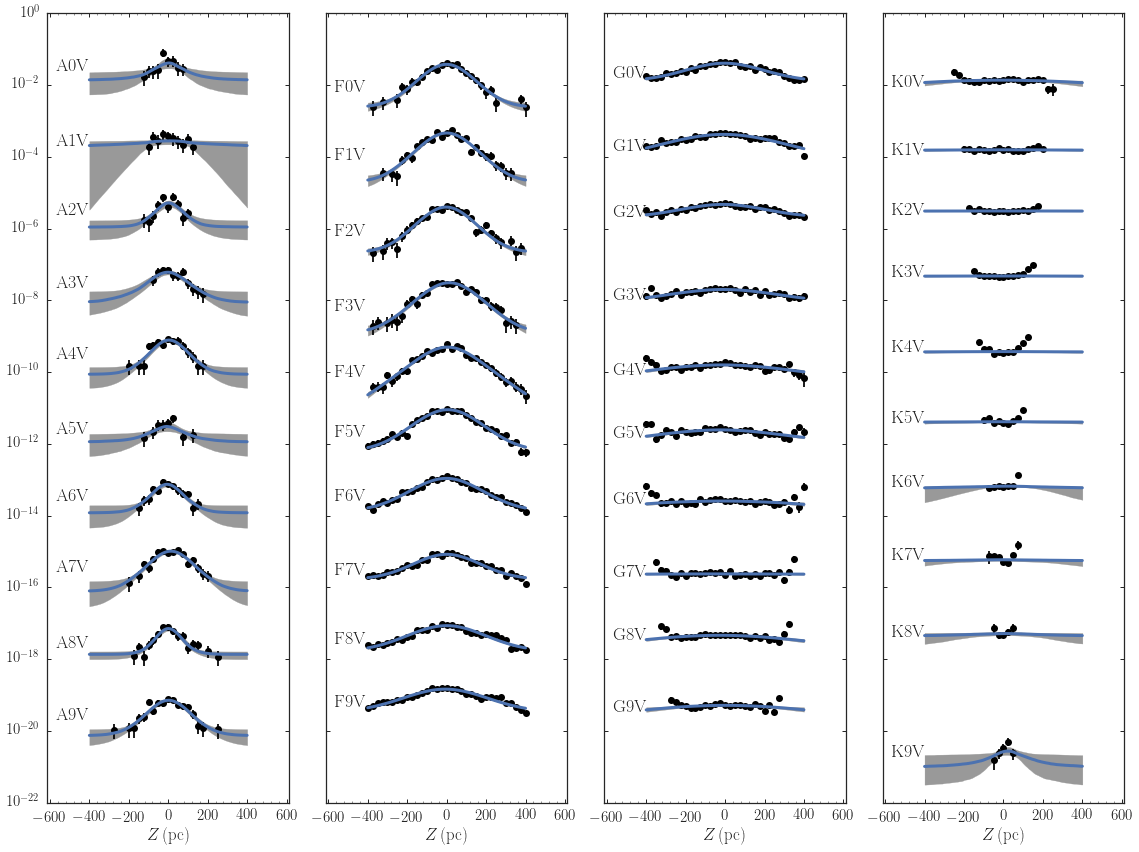

In [42]:
figsize(16,12)
npop_plot= 40
dii= dpop
zs= numpy.linspace(-0.4,0.4,101)
include_range= True
for ii in tqdm.tqdm(range(0,npop_plot)):
    c= all_counts[ii]
    ec= all_counts_unc[ii]
    raw= c*all_effvol[ii]
    ef= all_effvol[ii]/(good_maxxy(sp['SpT'][sp_indx][ii])**2.*numpy.pi*(zbins[1]-zbins[0]))
    good_dens_indx= (ef > sf_unc*numpy.nanmax(ef))*(c > 0.)*((ef == ef[len(ef)//2])+(ef > 10.**-5.))*(raw > 4.)
    subplot(1,4,ii//10+1)
    bovy_plot.bovy_plot(1000.*0.5*(numpy.roll(zbins,-1)+zbins)[:-1][good_dens_indx],
                        c[good_dens_indx]/10.**6./10**(2.*(ii%10))/10**((ii//10)/2.),
                        'ko',gcf=True,overplot=(ii%10 > 0),
                        yrange=[10.**-22.,10.**0.],
                        semilogy=True,
                        xrange=[1000.*(zbins[0]-0.2),1000.*(zbins[-1]+0.2)],
                        zorder=2,
                        xlabel=r'$Z\,(\mathrm{pc})$')
    errorbar(1000.*0.5*(numpy.roll(zbins,-1)+zbins)[:-1][good_dens_indx],
             c[good_dens_indx]/10.**6./10**(2.*(ii%10))/10**((ii//10)/2.),
             ec[good_dens_indx]/10.**6./10**(2.*(ii%10))/10**((ii//10)/2.),
             marker='None',ls='None',color='k',capsize=0,zorder=1)
    if include_range:
        s= sample_sech2(c,ec,ef,raw,zbins,include_outlier=True,plots=False,nsamples=10000,verbose=False)
        all_prof= sech2profile(numpy.tile(zs,(10000,1)),
                               numpy.tile(s.T,(len(zs),1,1)).T)/10.**6./10**(2.*(ii%10))/10**((ii//10)/2.)
        all_prof= numpy.sort(all_prof,axis=0)
        plot(1000.*zs,all_prof[int(numpy.floor(0.5*len(all_prof)))],color=sns.color_palette()[0],lw=3.)
        fill_between(1000.*zs,
                     all_prof[int(numpy.floor(0.16*len(all_prof)))],all_prof[int(numpy.floor(0.84*len(all_prof)))],
                    color='0.6',zorder=0)
    else:
        p= fit_sech2(c,ec,ef,raw,zbins,include_outlier=True,verbose=False)
        plot(1000.*zs,sech2profile(zs,p)/10.**6./10**(2.*(ii%10))/10**((ii//10)/2.),lw=3.,color=sns.color_palette()[0])
    if ii/10 > 0:
        gca().yaxis.set_major_formatter(NullFormatter())
    bovy_plot.bovy_text(-570.,
                        numpy.exp(0.5*(numpy.log(numpy.nanmax(c[good_dens_indx]))
                                       +numpy.log(numpy.nanmin(c[good_dens_indx]))))\
                            /10.**6./10**(2.*(ii%10))/10**((ii//10)/2.)/1.5,
                        r'$\mathrm{%s}$' % (sp['SpT'][sp_indx][ii]),size=18.)
tight_layout()

In [43]:
nsamples= 10000
all_p_hp= numpy.empty((npop,5))
all_s_hp= numpy.empty((npop,5,nsamples))
all_s_med_hp= numpy.empty((npop,5))
all_s_mad_hp= numpy.empty((npop,5))
all_s_low_hp= numpy.empty((npop,5))
all_s_high_hp= numpy.empty((npop,5))
all_s_vlow_hp= numpy.empty((npop,5))
all_s_vhigh_hp= numpy.empty((npop,5))
for ii in tqdm.tqdm(range(npop)):
    c= all_counts[ii]
    ec= all_counts_unc[ii]
    raw= c*all_effvol[ii]
    ef= all_effvol[ii]/(good_maxxy(sp['SpT'][sp_indx][ii])**2.*numpy.pi*(zbins[1]-zbins[0]))
    all_p_hp[ii]= fit_sech2(c,ec,ef,raw,zbins,verbose=False,include_outlier=True)
    ts= sample_sech2(c,ec,ef,raw,zbins,verbose=False,include_outlier=True,nsamples=nsamples)
    if len(ts.shape) == 1:
        all_s_hp[ii,:,:]= numpy.nan
        all_s_med_hp[ii,:]= numpy.nan
        all_s_mad_hp[ii,:]= numpy.nan
        all_s_low_hp[ii,:]= numpy.nan
        all_s_high_hp[ii,:]= numpy.nan
    else:
        all_s_hp[ii]= ts
        all_s_med_hp[ii]= numpy.nanmedian(ts,axis=1)
        all_s_mad_hp[ii]= numpy.nanmedian(numpy.fabs(ts.T-all_s_med_hp[ii]).T,axis=1)
        for jj in range(len(all_s_hp[ii])):
            all_s_low_hp[ii,jj]= all_s_hp[ii,jj,numpy.argsort(all_s_hp[ii,jj])][int(numpy.floor(0.16*nsamples))]
            all_s_high_hp[ii,jj]= all_s_hp[ii,jj,numpy.argsort(all_s_hp[ii,jj])][int(numpy.floor(0.84*nsamples))]            
            all_s_vlow_hp[ii,jj]= all_s_hp[ii,jj,numpy.argsort(all_s_hp[ii,jj])][int(numpy.floor(0.01*nsamples))]
            all_s_vhigh_hp[ii,jj]= all_s_hp[ii,jj,numpy.argsort(all_s_hp[ii,jj])][int(numpy.floor(0.99*nsamples))]            

The scale height is:

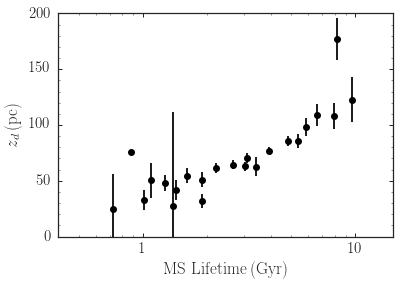

In [44]:
figsize(6,4)
tnpop= 23 # to where we get lower lims and where we have ages
lage_mid= sp_lage[:tnpop:skip]
dlage= numpy.roll(lage_mid,-1)-lage_mid
page= lage_mid-0.5*dlage
page[-1]= lage_mid[-1]+dlage[-3]*0.5
page= 9.+numpy.log10(ms_lifetime(m_mid))
bovy_plot.bovy_plot(10.**(page-9.)[:tnpop],
                    1000.*numpy.exp(all_p_hp[:tnpop:skip,1]),
                    'ko',semilogx=True,
                    xrange=[0.400,15.],
                    yrange=[0.,200.],
                    xlabel=r'$\mathrm{MS\ Lifetime}\,(\mathrm{Gyr})$',
                    ylabel=r'$z_d\,(\mathrm{pc})$')
errorbar(10.**(page-9.)[:tnpop],
         1000.*numpy.exp(all_p_hp[:tnpop:skip,1]),
        yerr=1000.*0.5*(numpy.exp(all_s_high_hp[:tnpop:skip,1])-numpy.exp(all_s_low_hp[:tnpop:skip,1])),
        marker='None',ls='None',capsize=0,color='k')
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))

The Sun's height above the plane in this case is

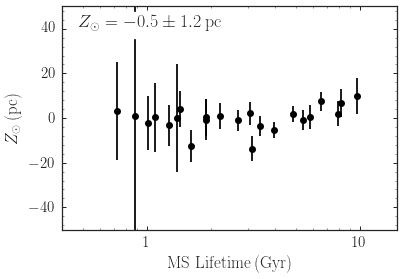

In [45]:
start= 0
tnpop= 23
skip= 1
m_mid= sp_mass[:tnpop:skip]
page= 9.+numpy.log10(ms_lifetime(m_mid))
figsize(6,4)
bovy_plot.bovy_plot(10.**(page-9.)[:tnpop],
                    1000.*all_p_hp[:tnpop:skip,2],
                    'ko',semilogx=True,
                    xrange=[0.400,15.],
                    yrange=[-50.,50.],
                    xlabel=r'$\mathrm{MS\ Lifetime}\,(\mathrm{Gyr})$',
                    ylabel=r'$Z_\odot\,(\mathrm{pc})$')
yerr= 1000.*0.5*((all_s_high_hp[:tnpop:skip,2])-(all_s_low_hp[:tnpop:skip,2]))
errorbar(10.**(page-9.)[:tnpop],
         1000.*(all_p_hp[:tnpop:skip,2]),
        yerr=yerr,
        marker='None',ls='None',capsize=0,color='k')
zsun_med= numpy.nanmedian(all_s_med_hp[start:tnpop,2])*1000.
zsun_mad= numpy.nanmedian(numpy.fabs(1000.*all_s_med_hp[start:tnpop,2]-zsun_med))/1.4826
zsun_mean= numpy.sum(1000.*all_p_hp[start:tnpop:skip,2]/yerr[start:]**2.)/numpy.sum(1./yerr[start:]**2.)
zsun_std= numpy.sqrt(1./numpy.sum(1./yerr[start:]**2.))
bovy_plot.bovy_text(r'$Z_\odot = %.1f \pm %.1f\,\mathrm{pc}$' % (zsun_mean,zsun_std),
                   top_left=True,size=18.,backgroundcolor='w')
#print(zsun_med,zsun_mad,zsun_mean,zsun_std)
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))

Thus, the density profiles and the Solar offset are almost the same for the narrower cylinders as they are for the wider cylinders for A and F dwarfs.

## Stellar densities along the giant branch

Next, we will determine stellar density profiles for different giant stars. First we again look at how many stars there are as a function of position along the giant branch (note the red clump at $M_J \approx -1$):

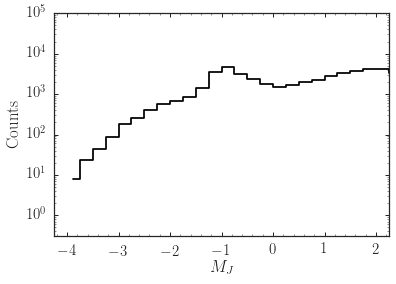

In [46]:
good_plx_indx= (tgas['parallax'] > min_plx)*(jk != 0.)
giant_index= good_plx_indx\
                *(jk > 0.32)*(mj < giant_sequence_cut(jk,low=True))*(mj > giant_sequence_cut(jk,low=False))
# MJ boundaries
dmj= 0.25
mj_bins= numpy.arange(2.5,-4-dmj,-dmj)
mj_mid= 0.5*(numpy.roll(mj_bins,-1)+mj_bins)[:-1]
figsize(6,4)
counts, edges= numpy.histogram(mj[giant_index],bins=mj_bins[::-1])
bovy_plot.bovy_plot(mj_mid[::-1],counts,ls='steps-mid',color='k',semilogy=True,
                   xrange=[-4.25,2.25],yrange=[.3,10.**5.],
                   xlabel=r'$M_J$',ylabel=r'$\mathrm{Counts}$')

An example density profile and fit:

In [47]:
ii= 12
dii= 4
print(mj_mid[ii])
tindx= giant_index*(mj < mj_bins[ii])*(mj > mj_bins[ii+dii])
good_relplx_indx= tindx\
                    *(mj < giant_sequence_cut(jk,low=True,tight=True))\
                    *(mj > giant_sequence_cut(jk,low=False,tight=True))\
                    *(tgas['parallax']/tgas['parallax_error'] > (good_relplx(mj)))
zbins= numpy.arange(-0.4125,0.425,0.025)
c,ec,ef= vertical_counts_onepop(zbins,dataXY[tindx],dataZ[tindx],
                             jk[good_relplx_indx],mj[good_relplx_indx],
                             'giant',maxxy=0.25)

-0.625


Optimization terminated successfully.
         Current function value: 10.471053
         Iterations: 7
         Function evaluations: 442


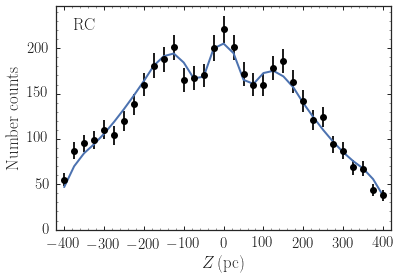

In [48]:
figsize(6,4)
p= fit_sech2(c,ec,ef,c*ef,zbins,verbose=True,include_outlier=True)
bovy_plot.bovy_plot(500.*(numpy.roll(zbins,-1)+zbins)[:-1],
                    sech2profile(0.5*(numpy.roll(zbins,-1)+zbins)[:-1],p)*ef,'-',
                    color=sns.color_palette()[0],semilogy=False,
                    lw=2.,zorder=2,
                    xlabel=r'$Z\,(\mathrm{pc})$',
                    ylabel=r'$\mathrm{Number\ counts}$',
                    xrange=[-420.,420.],
                    yrange=[0.,1.2*numpy.amax(sech2profile(0.5*(numpy.roll(zbins,-1)+zbins)[:-1],p)*ef)])
errorbar(500.*(numpy.roll(zbins,-1)+zbins)[:-1],c*ef,yerr=ec*ef,color='k',marker='o',
        ls='None')
bovy_plot.bovy_text(r'$\mathrm{RC}$',size=17.,top_left=True)
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','numcounts_rc.pdf'),
                bbox_inches='tight')

Optimization terminated successfully.
         Current function value: 10.471053
         Iterations: 7
         Function evaluations: 442
(array([  1.16084467e+01,  -1.86883216e+00,   2.16760250e-02,
         1.84046378e-02,   9.44618874e+01]), array([  1.10023214e+05,   1.54303758e-01,   1.02191266e+00,
         1.01857505e+00,   1.05749043e+41]))
(array([  2.74758222e-02,   7.40482105e-02,   5.43591703e-03,
         5.12480877e-02,   9.08473579e+05]), array([ 1.02785676,  1.07685872,  1.00545072,  1.05258399,         inf]))


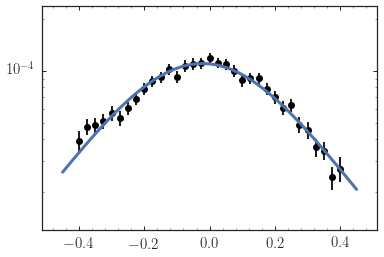

In [49]:
good_dens_indx= (ef > 0.1*numpy.nanmax(ef))
bovy_plot.bovy_plot(0.5*(numpy.roll(zbins,-1)+zbins)[:-1][good_dens_indx],c[good_dens_indx]/10.**9.,'ko',
                    yrange=[0.5*numpy.nanmin(c[good_dens_indx]/10.**9.),2.*numpy.nanmax(c[good_dens_indx]/10.**9.)],
                    semilogy=True,
                    xrange=[zbins[0]-0.1,zbins[-1]+0.1])
errorbar(0.5*(numpy.roll(zbins,-1)+zbins)[:-1][good_dens_indx],c[good_dens_indx]/10.**9.,
         ec[good_dens_indx]/10.**9.,marker='None',ls='None',color='k')
zs= numpy.linspace(-0.45,0.45,101)
p= fit_sech2(c,ec,ef,c*ef,zbins,verbose=True,include_outlier=True)
s= sample_sech2(c,ec,ef,c*ef,zbins,verbose=False,include_outlier=True,nsamples=10000)
plot(zs,sech2profile(zs,p)/10.**9.,lw=3.,color=sns.color_palette()[0])
print(p,numpy.exp(p))
print(numpy.std(s,axis=1),numpy.exp(numpy.std(s,axis=1)))

Fit all giant populations:

In [50]:
zbins= numpy.arange(-0.4125,0.425,0.025)
npop= len(mj_bins)-1
dpop= 1
savefilename= 'counts_vert_giants_dmj0p25.sav'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        all_counts= pickle.load(savefile)
        all_counts_unc= pickle.load(savefile)
        all_effvol= pickle.load(savefile)
else:
    all_counts= numpy.empty((npop,len(zbins)-1))
    all_counts_unc= numpy.empty((npop,len(zbins)-1))
    all_effvol= numpy.empty((npop,len(zbins)-1))
    multiOut= multi.parallel_map(\
                lambda x: vertical_counts_onepop(zbins,
                                                 dataXY[giant_index*(mj < mj_bins[x])*(mj > mj_bins[x+dpop])],
                                                 dataZ[giant_index*(mj < mj_bins[x])*(mj > mj_bins[x+dpop])],
                                                 jk[giant_index*(mj < mj_bins[x])*(mj > mj_bins[x+dpop])\
                                                    *(mj < giant_sequence_cut(jk,low=True,tight=True))\
                                                    *(mj > giant_sequence_cut(jk,low=False,tight=True))\
                                                    *(tgas['parallax']/tgas['parallax_error'] > (good_relplx(mj)))],
                                                 mj[giant_index*(mj < mj_bins[x])*(mj > mj_bins[x+dpop])\
                                                    *(mj < giant_sequence_cut(jk,low=True,tight=True))\
                                                    *(mj > giant_sequence_cut(jk,low=False,tight=True))\
                                                    *(tgas['parallax']/tgas['parallax_error'] > (good_relplx(mj)))],
                                                 'giant',
                                                 maxxy=0.25),
                                range(npop),numcores=10)
    for ii in range(npop):
        all_counts[ii]= multiOut[ii][0]
        all_counts_unc[ii]= multiOut[ii][1]
        all_effvol[ii]= multiOut[ii][2]
    save_pickles(savefilename,all_counts,all_counts_unc,all_effvol)

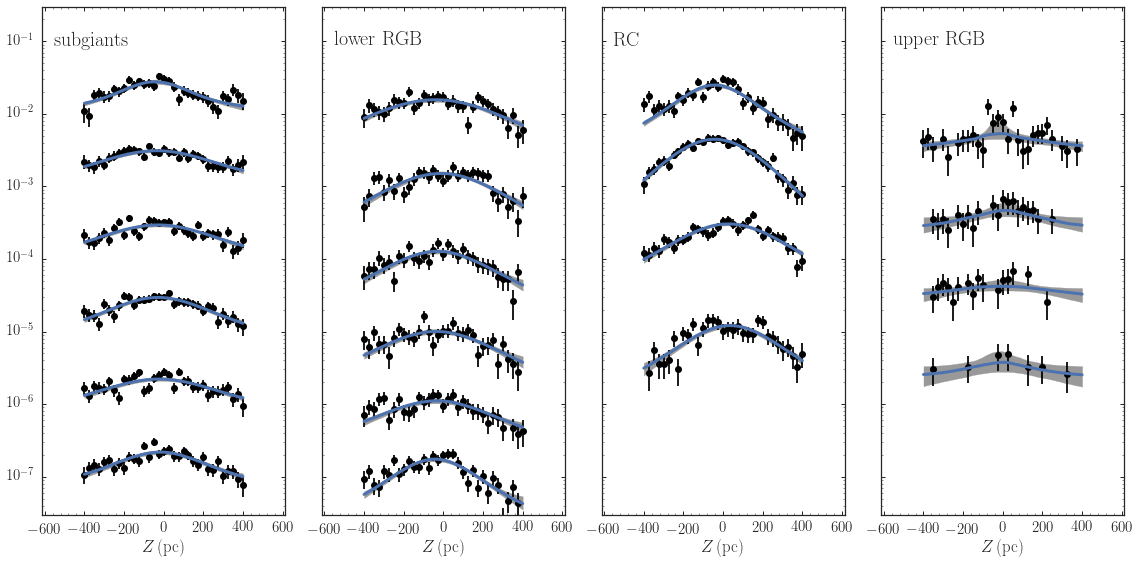

In [51]:
figsize(16,8.)
npop_plot= npop-6
dii= dpop
zs= numpy.linspace(-0.4,0.4,101)
include_range= True
type_break_indx= [6,12,16]
addii= [0 for ii in range(type_break_indx[0])]
addii.extend([10-type_break_indx[0] for ii in range(type_break_indx[1]-type_break_indx[0])])
addii.extend([20-type_break_indx[1] for ii in range(type_break_indx[2]-type_break_indx[1])])
addii.extend([30-type_break_indx[2] for ii in range(npop_plot-type_break_indx[2])])
ii= 0
base_ii= 0
labels= [r'$\mathrm{subgiants}$',
         r'$\mathrm{lower\ RGB}$',
         r'$\mathrm{RC}$',
         r'$\mathrm{upper\ RGB}$']
for base_ii in tqdm.tqdm(range(npop_plot)):
    ii= base_ii
    c= all_counts[ii]
    ec= all_counts_unc[ii]
    raw= c*all_effvol[ii]
    ef= all_effvol[ii]/(0.25**2.*numpy.pi*(zbins[1]-zbins[0]))
    good_dens_indx= (ef > sf_unc*numpy.nanmax(ef))*(c > 0.)*((ef == ef[len(ef)//2])+(ef > 10.**-5.))*(raw > 4.)
    ii+= addii[base_ii]
    subplot(1,4,ii//10+1)
    bovy_plot.bovy_plot(1000.*0.5*(numpy.roll(zbins,-1)+zbins)[:-1][good_dens_indx],
                        c[good_dens_indx]/10.**6./10**(1.*(ii%10)),
                        'ko',gcf=True,overplot=(ii%10 > 0),
                        yrange=[3.*10.**-8.,3.*10.**-1.],
                        semilogy=True,
                        xrange=[1000.*(zbins[0]-0.2),1000.*(zbins[-1]+0.2)],
                        zorder=2,
                        xlabel=r'$Z\,(\mathrm{pc})$')
    errorbar(1000.*0.5*(numpy.roll(zbins,-1)+zbins)[:-1][good_dens_indx],
             c[good_dens_indx]/10.**6./10**(1.*(ii%10)),
             ec[good_dens_indx]/10.**6./10**(1.*(ii%10)),
             marker='None',ls='None',color='k',capsize=0,zorder=1)
    if include_range:
        s= sample_sech2(c,ec,ef,raw,zbins,include_outlier=True,plots=False,nsamples=10000,verbose=False)
        all_prof= sech2profile(numpy.tile(zs,(10000,1)),
                               numpy.tile(s.T,(len(zs),1,1)).T)/10.**6./10**(1.*(ii%10))
        all_prof= numpy.sort(all_prof,axis=0)
        plot(1000.*zs,all_prof[int(numpy.floor(0.5*len(all_prof)))],color=sns.color_palette()[0],lw=3.)
        fill_between(1000.*zs,
                     all_prof[int(numpy.floor(0.16*len(all_prof)))],all_prof[int(numpy.floor(0.84*len(all_prof)))],
                    color='0.6',zorder=0)
    else:
        p= fit_sech2(c,ec,ef,raw,zbins,include_outlier=True,verbose=False)
        plot(1000.*zs,sech2profile(zs,p)/10.**6./10**(1.*(ii%10)),lw=3.,color=sns.color_palette()[0])
    if ii/10 > 0:
        gca().yaxis.set_major_formatter(NullFormatter())
    if ii%10 == 0: bovy_plot.bovy_text(labels[ii//10],size=20.,top_left=True)
tight_layout()
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','densprofiles_giants.pdf'),
                bbox_inches='tight')

In [52]:
nsamples= 10000
all_p= numpy.empty((npop,5))
all_s= numpy.empty((npop,5,nsamples))
all_s_med= numpy.empty((npop,5))
all_s_mad= numpy.empty((npop,5))
all_s_low= numpy.empty((npop,5))
all_s_high= numpy.empty((npop,5))
all_s_vlow= numpy.empty((npop,5))
all_s_vhigh= numpy.empty((npop,5))
numpy.random.seed(4)
for ii in tqdm.tqdm(range(npop)):
    c= all_counts[ii]
    ec= all_counts_unc[ii]
    raw= c*all_effvol[ii]
    ef= all_effvol[ii]/(0.25**2.*numpy.pi*(zbins[1]-zbins[0]))
    all_p[ii]= fit_sech2(c,ec,ef,raw,zbins,verbose=False,include_outlier=True)
    ts= sample_sech2(c,ec,ef,raw,zbins,verbose=False,include_outlier=True,nsamples=nsamples)
    if len(ts.shape) == 1:
        all_s[ii,:,:]= numpy.nan
        all_s_med[ii,:]= numpy.nan
        all_s_mad[ii,:]= numpy.nan
        all_s_low[ii,:]= numpy.nan
        all_s_high[ii,:]= numpy.nan
    else:
        all_s[ii]= ts
        all_s_med[ii]= numpy.nanmedian(ts,axis=1)
        all_s_mad[ii]= numpy.nanmedian(numpy.fabs(ts.T-all_s_med[ii]).T,axis=1)
        for jj in range(len(all_s[ii])):
            all_s_low[ii,jj]= all_s[ii,jj,numpy.argsort(all_s[ii,jj])][int(numpy.floor(0.16*nsamples))]
            all_s_high[ii,jj]= all_s[ii,jj,numpy.argsort(all_s[ii,jj])][int(numpy.floor(0.84*nsamples))]            
            all_s_vlow[ii,jj]= all_s[ii,jj,numpy.argsort(all_s[ii,jj])][int(numpy.floor(0.01*nsamples))]
            all_s_vhigh[ii,jj]= all_s[ii,jj,numpy.argsort(all_s[ii,jj])][int(numpy.floor(0.99*nsamples))]            

The mid-plane density as a function of $M_J$ is:

In [53]:
Zs= numpy.arange(0.003,0.031,0.001)
parsec= PadovaIsochrone(type='2mass-spitzer-wise',Z=Zs,parsec=True)

In [54]:
import isodist.imf

In [55]:
def parsec_samples(pa):
    lages= pa.logages()
    lages= lages[(lages > 6.)*(lages <=10.)]
    mjs= []
    ws= []
    allw= 0.
    for lage in lages:
        for Z in Zs:
            tiso= pa(lage,Z=Z)
            # Use same cuts as in the data to select giants
            tindx= (tiso['J']-tiso['Ks'] > 0.32)*(tiso['J']-tiso['Ks'] < 1.)\
                        *(tiso['J'] < giant_sequence_cut(tiso['J']-tiso['Ks'],tight=False,low=True))\
                        *(tiso['J'] > giant_sequence_cut(tiso['J']-tiso['Ks'],tight=False))
            mjs.extend(tiso['J'][tindx].astype('float'))
            int_IMF= tiso['int_IMF']
            dN= (numpy.roll(int_IMF,-1)-int_IMF)/(int_IMF[-1]-int_IMF[0])
            # SFH
            dN*= 10**(lage-9.)
            # Metallicity distribution
            dN*= localfehdist(Z2FEH(Z,parsec=True))/Z
            ws.extend(dN[tindx])
            allw+= numpy.sum((tiso['M_ini']*dN)[(dN > 0.)*(tiso['M_ini'] > 0.72)])
    return (numpy.array(mjs).astype('float'),numpy.array(ws),allw)

Optimization terminated successfully.
         Current function value: 32.870764
         Iterations: 13
         Function evaluations: 805


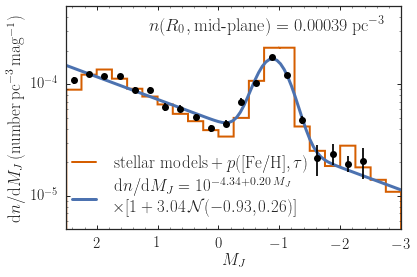

In [56]:
figsize(6,4)
tnpop= npop-6
skip= 1
dmj= -(mj_bins[1]-mj_bins[0])
bovy_plot.bovy_plot(mj_mid[:tnpop:skip],
                    numpy.exp(all_p[:tnpop:skip,0])/10.**9./dmj,
                    'ko',semilogy=True,zorder=2,
                    xrange=[2.5,-3.],
                    yrange=[5.*10.**-6.,5.*10.**-4.],
                    xlabel=r'$M_J$',
                    ylabel=r'$\mathrm{d} n / \mathrm{d} M_J\,(\mathrm{number\,pc}^{-3}\,\mathrm{mag}^{-1})$')
errorbar(mj_mid[:tnpop:skip],
        numpy.exp(all_p[:tnpop:skip,0])/10.**9./dmj,
        yerr=0.5*(numpy.exp(all_s_high[:tnpop:skip,0])-numpy.exp(all_s_low[:tnpop:skip,0]))/10.**9./dmj,
        marker='None',ls='None',capsize=0,color='k',zorder=1)
# Model: 2nd order polynomial x Gaussian
deg= 1
def giant_lumfunc(p,mj):
    return numpy.exp(numpy.polyval(p[:deg+1],mj)\
            +numpy.log(1.+numpy.exp(p[deg+1])/numpy.sqrt(2.*numpy.pi)
                       *numpy.exp(-p[deg+2]-0.5*(mj-p[deg+3])**2.*numpy.exp(-2.*p[deg+2]))))
def opt_func(p):
    return 0.5*numpy.sum((giant_lumfunc(p,mj_mid[:tnpop:skip])-numpy.exp(all_p[:tnpop:skip,0])/10.**9./dmj)**2.\
                         /(0.5*(numpy.exp(all_s_high[:tnpop:skip,0])-numpy.exp(all_s_low[:tnpop:skip,0]))/10.**9./dmj)**2.)
p= optimize.fmin_powell(opt_func,numpy.array([0.,-5.*numpy.log(10.),-5.*numpy.log(10.),numpy.log(0.2),-1.]))
totnum= (integrate.quad(lambda x: giant_lumfunc(p,x),-4.,2.5)[0])
mjs= numpy.linspace(3.,-3.,101)
line= plot(mjs,giant_lumfunc(p,mjs),lw=3.,zorder=0)
mj,w,tw= parsec_samples(parsec)
_= hist(mj,weights=w*4*0.01/numpy.sum(tw),bins=22,histtype='step',lw=2.,range=[-3.,2.5],
        color=sns.color_palette('colorblind')[2],zorder=0)
hist_line = mlines.Line2D([], [],color=sns.color_palette('colorblind')[2],lw=2.)
gcf().legend((hist_line,line[0],),
              (r'$\mathrm{stellar\ models}+p([\mathrm{Fe/H}],\tau)$',
               r'$\mathrm{d} n / \mathrm{d} M_J = 10^{%.2f + %.2f\,M_J}$' \
                   % (p[1]/numpy.log(10.),p[0]/numpy.log(10.))
               +'\n'+r'$\times[1 + %.2f\,\mathcal{N}(%.2f,%.2f)]$' % (numpy.exp(p[deg+1]),p[deg+3],numpy.exp(p[deg+2])),),
              bbox_to_anchor=(.75,.475),
              numpoints=8,
              prop={'size':17},
              frameon=False)
bovy_plot.bovy_text(r'$n(R_0,\mathrm{mid\hbox{-}plane}) = %.5f\,\mathrm{pc}^{-3}$' \
                    % totnum,
                    top_right=True,size=18.)
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','lumfunc_giants.pdf'),
                bbox_inches='tight')

We can also use isochrone models to convert this approximately to a mass density function:

In [57]:
iso= parsec
lages= iso.logages()
lages= lages[lages > 7.]
#lages= lages[lages == 9.8]
all_mj= []
all_mact= []
all_w= []
for ii,lage in enumerate(lages):
    for jj, tz in enumerate(Zs):
        tp= iso(logage=lage,Z=tz)
        if False:
            tindx= numpy.ones_like(tp['logg'],dtype='bool')
        else:
            tindx= (tp['logg'] < 3.75)*((tp['J']-tp['Ks']) > 0.4)
        all_mj.extend(list(tp['J'][tindx]))
        all_mact.extend(list(tp['M_act'][tindx]))
        all_w.extend(list(numpy.ones_like(tp['J'][tindx])*localfehdist(numpy.log10(tz/0.017))/tz*10.**(lage-9.)))
all_mj= numpy.array(all_mj)
all_mact= numpy.array(all_mact)
all_w= numpy.array(all_w)
sum_mact,_= numpy.histogram(all_mj,bins=mj_bins[::-1],weights=all_w*all_mact)
sum_mact2,_= numpy.histogram(all_mj,bins=mj_bins[::-1],weights=all_w*all_mact**2.)
hist_mj,_= numpy.histogram(all_mj,bins=mj_bins[::-1],weights=all_w)

Optimization terminated successfully.
         Current function value: 37.592153
         Iterations: 12
         Function evaluations: 772


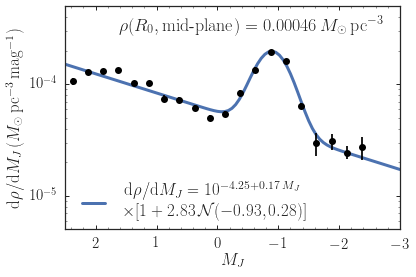

In [58]:
figsize(6,4)
tnpop= npop-6
skip= 1
dmj= -(mj_bins[1]-mj_bins[0])
tmass= (sum_mact/hist_mj)[::-1][:tnpop:skip]+0.*numpy.sqrt(sum_mact2/hist_mj-(sum_mact/hist_mj)**2.)[::-1][:tnpop:skip]
bovy_plot.bovy_plot(mj_mid[:tnpop:skip],
                    numpy.exp(all_p[:tnpop:skip,0])/10.**9./dmj*tmass,
                    'ko',semilogy=True,zorder=2,
                    xrange=[2.5,-3.],
                    yrange=[5.*10.**-6.,5.*10.**-4.],
                    xlabel=r'$M_J$',
                    ylabel=r'$\mathrm{d} \rho / \mathrm{d} M_J\,(M_\odot\,\mathrm{pc}^{-3}\,\mathrm{mag}^{-1})$')
errorbar(mj_mid[:tnpop:skip],
        numpy.exp(all_p[:tnpop:skip,0])/10.**9./dmj*tmass,
        yerr=0.5*(numpy.exp(all_s_high[:tnpop:skip,0])-numpy.exp(all_s_low[:tnpop:skip,0]))/10.**9./dmj,
        marker='None',ls='None',capsize=0,color='k',zorder=1)
# Model: 2nd order polynomial x Gaussian
deg= 1
def opt_func(p):
    return 0.5*numpy.sum((giant_lumfunc(p,mj_mid[:tnpop:skip])-numpy.exp(all_p[:tnpop:skip,0])/10.**9./dmj*tmass)**2.\
                         /(0.5*(numpy.exp(all_s_high[:tnpop:skip,0])-numpy.exp(all_s_low[:tnpop:skip,0]))/10.**9./dmj*tmass)**2.)
p= optimize.fmin_powell(opt_func,numpy.array([0.,-5.*numpy.log(10.),-5.*numpy.log(10.),numpy.log(0.2),-1.]))
totnum= (integrate.quad(lambda x: giant_lumfunc(p,x),-4.,2.5)[0])
mjs= numpy.linspace(3.,-3.,101)
line= plot(mjs,giant_lumfunc(p,mjs),lw=3.,zorder=0)
gcf().legend((line[0],),
              (r'$\mathrm{d} \rho / \mathrm{d} M_J = 10^{%.2f + %.2f\,M_J}$' \
                   % (p[1]/numpy.log(10.),p[0]/numpy.log(10.))
               +'\n'+r'$\times[1 + %.2f\,\mathcal{N}(%.2f,%.2f)]$' % (numpy.exp(p[deg+1]),p[deg+3],numpy.exp(p[deg+2])),),
              bbox_to_anchor=(.75,.375),
              numpoints=8,
              prop={'size':17},
              frameon=False)
bovy_plot.bovy_text(r'$\rho(R_0,\mathrm{mid\hbox{-}plane}) = %.5f\,M_\odot\,\mathrm{pc}^{-3}$' \
                    % totnum,
                    top_right=True,size=18.)
if False:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','massfunc_giants.pdf'),
                bbox_inches='tight')

The total density has an uncertainty of about $0.00005\,M_\odot\,\mathrm{pc}^{-3}$ because of the uncertainty in the mass-luminosity relation.

Write a table with the giant luminosity function:

In [59]:
tnpop= npop-6
skip= 1
table= [mj_mid[:tnpop:skip][::-1],
        numpy.exp(all_p[:tnpop:skip,0][::-1])/10.**5.,
        0.5*(numpy.exp(all_s_high[:tnpop:skip,0])-numpy.exp(all_s_low[:tnpop:skip,0]))[::-1]/10.**5.,
        numpy.exp(all_p[:tnpop:skip,0][::-1])/10.**5./dmj,
        0.5*(numpy.exp(all_s_high[:tnpop:skip,0])-numpy.exp(all_s_low[:tnpop:skip,0]))[::-1]/10.**5./dmj,
        numpy.cumsum(numpy.exp(all_p[:tnpop:skip,0][::-1])/10.**5.)]
table= Table(table,masked=True,
             names=['$M_J$',
                    '$n$','$\sigma(n)$',
                    '$\mathrm{d} n / \mathrm{d} M_J$','$\sigma(\mathrm{d} n / \mathrm{d} M_J)$',
                    '$\\rho(>M)$'])
table['$M_J$'].format= "{:.3f}"
table['$n$'].format= "{:.2f}"
table['$\sigma(n)$'].format= "{:.2f}"
table['$\mathrm{d} n / \mathrm{d} M_J$'].format= "{:.1f}"
table['$\sigma(\mathrm{d} n / \mathrm{d} M_J)$'].format= "{:.1f}"
table['$\\rho(>M)$'].format= "{:.2f}"
if save_tables:
    ascii.write(table,
                os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','giants_results_raw.dat'),
                Writer=ascii.Latex,
                latexdict = {'tabletype': 'table',
                             'units': {'$n$':'$(10^{-4}\,\mathrm{pc}^{-3})$',
                                        '$\mathrm{d} n / \mathrm{d} M_J$':'$(10^{-4}\,\mathrm{pc}^{-3}\,\mathrm{mag}^{-1})$'},
                            'col_align':'cr@{$\pm$}lr@{$\pm$}lc',
                            'header_end': '\\hline\\hline',
                            'header_start': '\\hline \\hline',
                            'data_end': '\\hline',
                            'caption':'Luminosity function of giants.'})
    # replace some lines
    with open(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','giants_results_raw.dat'),'r') as old_file:
        with open(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','giants_results.dat'),'w') as new_file:
            for line in old_file:
                if line.startswith('$M_J$ & '):
                    line= '$M_J$ & \multicolumn{2}{c}{$n$} & \multicolumn{2}{c}{$\mathrm{d} n / \mathrm{d} M_J$} & $n(<M_J)$ \\\\'
                elif line.startswith(' & $(10^{-4}\,\mathrm{pc}^{-3})$ &'):
                    line= ' & \multicolumn{2}{c}{$(10^{-4}\,\mathrm{pc}^{-3})$} & \multicolumn{2}{c}{$(10^{-4}\,\mathrm{pc}^{-3}\,\mathrm{mag}^{-1})$} & $(10^{-4}\,\mathrm{pc}^{-3})$ \\\\'
                new_file.write(line)
    os.remove(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','giants_results_raw.dat'))

Get density profile of entire classes:

In [60]:
zbins= numpy.arange(-0.4125,0.425,0.025)
broad_mj_bins= [2.5,1.,-0.5,-1.5,-4.]
npop= 4
savefilename= 'counts_vert_giants_dmjbroad.sav'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        all_counts= pickle.load(savefile)
        all_counts_unc= pickle.load(savefile)
        all_effvol= pickle.load(savefile)
else:
    all_counts= numpy.empty((npop,len(zbins)-1))
    all_counts_unc= numpy.empty((npop,len(zbins)-1))
    all_effvol= numpy.empty((npop,len(zbins)-1))
    multiOut= multi.parallel_map(\
                lambda x: vertical_counts_onepop(zbins,
                                                 dataXY[giant_index*(mj < broad_mj_bins[x])\
                                                        *(mj > broad_mj_bins[x+dpop])],
                                                 dataZ[giant_index*(mj < broad_mj_bins[x])\
                                                       *(mj > broad_mj_bins[x+dpop])],
                                                 jk[giant_index*(mj < broad_mj_bins[x])\
                                                    *(mj > broad_mj_bins[x+dpop])\
                                                    *(mj < giant_sequence_cut(jk,low=True,tight=True))\
                                                    *(mj > giant_sequence_cut(jk,low=False,tight=True))\
                                                    *(tgas['parallax']/tgas['parallax_error'] > (good_relplx(mj)))],
                                                 mj[giant_index*(mj < broad_mj_bins[x])\
                                                    *(mj > broad_mj_bins[x+dpop])\
                                                    *(mj < giant_sequence_cut(jk,low=True,tight=True))\
                                                    *(mj > giant_sequence_cut(jk,low=False,tight=True))\
                                                    *(tgas['parallax']/tgas['parallax_error'] > (good_relplx(mj)))],
                                                 'giant',
                                                 maxxy=0.25),
                                range(npop),numcores=10)
    for ii in range(npop):
        all_counts[ii]= multiOut[ii][0]
        all_counts_unc[ii]= multiOut[ii][1]
        all_effvol[ii]= multiOut[ii][2]
    save_pickles(savefilename,all_counts,all_counts_unc,all_effvol)

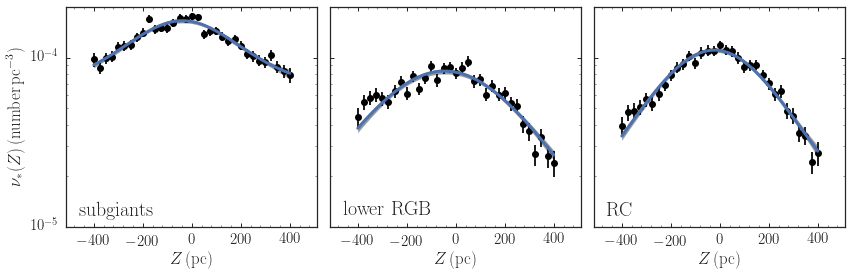

In [61]:
figsize(12,4)
include_range= True
labels= [r'$\mathrm{subgiants}$',
         r'$\mathrm{lower\ RGB}$',
         r'$\mathrm{RC}$',
         r'$\mathrm{upper\ RGB}$']
for ii in range(3):
    c= all_counts[ii]
    ec= all_counts_unc[ii]
    raw= c*all_effvol[ii]
    ef= all_effvol[ii]/(0.25**2.*numpy.pi*(zbins[1]-zbins[0]))
    good_dens_indx= (ef > sf_unc*numpy.nanmax(ef))*(c > 0.)*((ef == ef[len(ef)//2])+(ef > 10.**-5.))*(raw > 4.)
    subplot(1,3,ii+1)
    if ii == 0:
        tylabel= r'$\nu_*(Z)\,(\mathrm{number\,pc}^{-3})$'
    else:
        tylabel= None
    bovy_plot.bovy_plot(1000.*0.5*(numpy.roll(zbins,-1)+zbins)[:-1][good_dens_indx],
                        c[good_dens_indx]/10.**9.,
                        'ko',gcf=True,
                        yrange=[1.*10.**-5.,2.*10.**-4.],
                        semilogy=True,
                        xrange=[1000.*(zbins[0]-0.1),1000.*(zbins[-1]+0.1)],
                        zorder=2,
                        xlabel=r'$Z\,(\mathrm{pc})$',
                        ylabel=tylabel)
    errorbar(1000.*0.5*(numpy.roll(zbins,-1)+zbins)[:-1][good_dens_indx],
             c[good_dens_indx]/10.**9.,
             ec[good_dens_indx]/10.**9.,
             marker='None',ls='None',color='k',capsize=0,zorder=1)
    if include_range:
        s= sample_sech2(c,ec,ef,raw,zbins,include_outlier=True,plots=False,nsamples=10000,verbose=False)
        all_prof= sech2profile(numpy.tile(zs,(10000,1)),
                               numpy.tile(s.T,(len(zs),1,1)).T)/10.**9
        all_prof= numpy.sort(all_prof,axis=0)
        plot(1000.*zs,all_prof[int(numpy.floor(0.5*len(all_prof)))],color=sns.color_palette()[0],lw=3.)
        fill_between(1000.*zs,
                     all_prof[int(numpy.floor(0.16*len(all_prof)))],all_prof[int(numpy.floor(0.84*len(all_prof)))],
                    color='0.6',zorder=0)
    else:
        p= fit_sech2(c,ec,ef,raw,zbins,include_outlier=True,verbose=False)
        plot(1000.*zs,sech2profile(zs,p)/10.**9,lw=3.,color=sns.color_palette()[0])
    if ii > 0: gca().yaxis.set_major_formatter(NullFormatter())
    bovy_plot.bovy_text(labels[ii],size=20.,bottom_left=True)
tight_layout()
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','densprofiles_giants_coarse.pdf'),
                bbox_inches='tight')

In [62]:
nsamples= 10000
all_p= numpy.empty((npop,5))
all_s= numpy.empty((npop,5,nsamples))
all_s_med= numpy.empty((npop,5))
all_s_mad= numpy.empty((npop,5))
all_s_low= numpy.empty((npop,5))
all_s_high= numpy.empty((npop,5))
all_s_vlow= numpy.empty((npop,5))
all_s_vhigh= numpy.empty((npop,5))
for ii in tqdm.tqdm(range(npop)):
    c= all_counts[ii]
    ec= all_counts_unc[ii]
    if ii == 1: # seems problematic
        ec[:9]= 1000000.
        ec[-9:]= 1000000.
    raw= c*all_effvol[ii]
    ef= all_effvol[ii]/(0.25**2.*numpy.pi*(zbins[1]-zbins[0]))
    all_p[ii]= fit_sech2(c,ec,ef,raw,zbins,verbose=False,include_outlier=True)
    ts= sample_sech2(c,ec,ef,raw,zbins,verbose=False,include_outlier=True,nsamples=nsamples)
    if len(ts.shape) == 1:
        all_s[ii,:,:]= numpy.nan
        all_s_med[ii,:]= numpy.nan
        all_s_mad[ii,:]= numpy.nan
        all_s_low[ii,:]= numpy.nan
        all_s_high[ii,:]= numpy.nan
    else:
        all_s[ii]= ts
        all_s_med[ii]= numpy.nanmedian(ts,axis=1)
        all_s_mad[ii]= numpy.nanmedian(numpy.fabs(ts.T-all_s_med[ii]).T,axis=1)
        for jj in range(len(all_s[ii])):
            all_s_low[ii,jj]= all_s[ii,jj,numpy.argsort(all_s[ii,jj])][int(numpy.floor(0.16*nsamples))]
            all_s_high[ii,jj]= all_s[ii,jj,numpy.argsort(all_s[ii,jj])][int(numpy.floor(0.84*nsamples))]            
            all_s_vlow[ii,jj]= all_s[ii,jj,numpy.argsort(all_s[ii,jj])][int(numpy.floor(0.01*nsamples))]
            all_s_vhigh[ii,jj]= all_s[ii,jj,numpy.argsort(all_s[ii,jj])][int(numpy.floor(0.99*nsamples))]            

The scale height along the giant branch goes as:

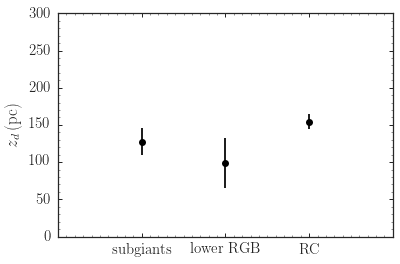

In [63]:
figsize(6,4)
tnpop= npop-1
skip= 1
bovy_plot.bovy_plot(numpy.arange(tnpop),
                    1000.*numpy.exp(all_p[:tnpop:skip,1]),
                    'ko',
                    xrange=[-1,tnpop],
                    yrange=[0.,300.],
                    ylabel=r'$z_d\,(\mathrm{pc})$')
errorbar(numpy.arange(tnpop),
                    1000.*numpy.exp(all_p[:tnpop:skip,1]),
        yerr=1000.*0.5*(numpy.exp(all_s_high[:tnpop:skip,1])-numpy.exp(all_s_low[:tnpop:skip,1])),
        marker='None',ls='None',capsize=0,color='k')
gca().xaxis.set_ticks(numpy.arange(tnpop))
_= gca().xaxis.set_ticklabels(labels[:tnpop])

The Sun's displacement is:

(array([ 41.91863121,  24.58267952,  21.67602502]), array([  6.80292397,  13.20885034,   5.651385  ]))
(24.801502116019293, 2.2412199281895218, 29.417847556632974, 4.1292095618135924)


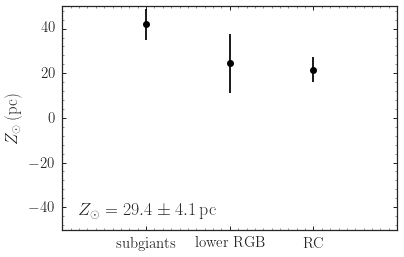

In [64]:
figsize(6,4)
bovy_plot.bovy_plot(numpy.arange(tnpop),
                    1000.*all_p[:tnpop:skip,2],
                    'ko',
                    xrange=[-1,tnpop],
                    yrange=[-50.,50.],
                    ylabel=r'$Z_\odot\,(\mathrm{pc})$')
yerr= 1000.*0.5*((all_s_high[:tnpop:skip,2])-(all_s_low[:tnpop:skip,2]))
errorbar(numpy.arange(tnpop),
         1000.*(all_p[:tnpop:skip,2]),
        yerr=yerr,
        marker='None',ls='None',capsize=0,color='k')
skip= 1
zsun_med= numpy.nanmedian(all_s_med[:tnpop:skip,2])*1000.
zsun_mad= numpy.nanmedian(numpy.fabs(1000.*all_s_med[:tnpop:skip,2]-zsun_med))/1.4826
zsun_mean= numpy.sum(1000.*all_p[:tnpop:skip,2]/yerr[::skip]**2.)/numpy.sum(1./yerr[::skip]**2.)
zsun_std= numpy.sqrt(1./numpy.sum(1./yerr[::skip]**2.))
bovy_plot.bovy_text(r'$Z_\odot = %.1f \pm %.1f\,\mathrm{pc}$' % (zsun_mean,zsun_std),
                   bottom_left=True,size=18.)
print(1000.*all_p[:tnpop:skip,2],yerr[::skip])
print(zsun_med,zsun_mad,zsun_mean,zsun_std)
gca().xaxis.set_ticks(numpy.arange(tnpop))
_= gca().xaxis.set_ticklabels(labels[:tnpop])

Similar to the dwarf sequence above, we investigate how these results for the giants depend on the bright end of the *TGAS* selection function. We fit again cutting out all stars with $J_G < 8$ and we get the following broad density profiles:

In [65]:
zbins= numpy.arange(-0.4125,0.425,0.025)
broad_mj_bins= [2.5,1.,-0.5,-1.5,-4.]
npop= 4
savefilename= 'counts_vert_giants_dmjbroad_cutbright.sav'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        all_counts= pickle.load(savefile)
        all_counts_unc= pickle.load(savefile)
        all_effvol= pickle.load(savefile)
else:
    all_counts= numpy.empty((npop,len(zbins)-1))
    all_counts_unc= numpy.empty((npop,len(zbins)-1))
    all_effvol= numpy.empty((npop,len(zbins)-1))
    multiOut= multi.parallel_map(\
                lambda x: vertical_counts_onepop(zbins,
                                                 dataXY[giant_index*(mj < broad_mj_bins[x])\
                                                        *(twomass['j_mag'] > 8.
                                                               -(numpy.median(jk[giant_index*(mj < broad_mj_bins[x])\
                                                    *(mj > broad_mj_bins[x+dpop])\
                                                    *(mj < giant_sequence_cut(jk,low=True,tight=True))\
                                                    *(mj > giant_sequence_cut(jk,low=False,tight=True))\
                                                    *(tgas['parallax']/tgas['parallax_error'] > (good_relplx(mj)))])**2.
                                                               +2.5*numpy.median(jk[giant_index*(mj < broad_mj_bins[x])\
                                                    *(mj > broad_mj_bins[x+dpop])\
                                                    *(mj < giant_sequence_cut(jk,low=True,tight=True))\
                                                    *(mj > giant_sequence_cut(jk,low=False,tight=True))\
                                                    *(tgas['parallax']/tgas['parallax_error'] > (good_relplx(mj)))])))\
                                                         *(mj > broad_mj_bins[x+dpop])],
                                                 dataZ[giant_index*(mj < broad_mj_bins[x])\
                                                       *(twomass['j_mag'] > 8.
                                                               -(numpy.median(jk[giant_index*(mj < broad_mj_bins[x])\
                                                    *(mj > broad_mj_bins[x+dpop])\
                                                    *(mj < giant_sequence_cut(jk,low=True,tight=True))\
                                                    *(mj > giant_sequence_cut(jk,low=False,tight=True))\
                                                    *(tgas['parallax']/tgas['parallax_error'] > (good_relplx(mj)))])**2.
                                                               +2.5*numpy.median(jk[giant_index*(mj < broad_mj_bins[x])\
                                                    *(mj > broad_mj_bins[x+dpop])\
                                                    *(mj < giant_sequence_cut(jk,low=True,tight=True))\
                                                    *(mj > giant_sequence_cut(jk,low=False,tight=True))\
                                                    *(tgas['parallax']/tgas['parallax_error'] > (good_relplx(mj)))])))\
                                                         *(mj > broad_mj_bins[x+dpop])],
                                                 jk[giant_index*(mj < broad_mj_bins[x])\
                                                    *(mj > broad_mj_bins[x+dpop])\
                                                    *(mj < giant_sequence_cut(jk,low=True,tight=True))\
                                                    *(mj > giant_sequence_cut(jk,low=False,tight=True))\
                                                    *(tgas['parallax']/tgas['parallax_error'] > (good_relplx(mj)))],
                                                 mj[giant_index*(mj < broad_mj_bins[x])\
                                                    *(mj > broad_mj_bins[x+dpop])\
                                                    *(mj < giant_sequence_cut(jk,low=True,tight=True))\
                                                    *(mj > giant_sequence_cut(jk,low=False,tight=True))\
                                                    *(tgas['parallax']/tgas['parallax_error'] > (good_relplx(mj)))],
                                                 'giant',
                                                 maxxy=0.25,cutbright=True),
                                range(npop),numcores=10)
    for ii in range(npop):
        all_counts[ii]= multiOut[ii][0]
        all_counts_unc[ii]= multiOut[ii][1]
        all_effvol[ii]= multiOut[ii][2]
    save_pickles(savefilename,all_counts,all_counts_unc,all_effvol)

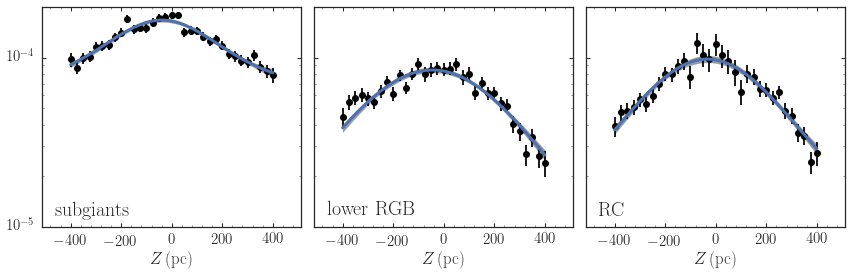

In [66]:
figsize(12,4)
include_range= True
labels= [r'$\mathrm{subgiants}$',
         r'$\mathrm{lower\ RGB}$',
         r'$\mathrm{RC}$',
         r'$\mathrm{upper\ RGB}$']
for ii in range(3):
    c= all_counts[ii]
    ec= all_counts_unc[ii]
    raw= c*all_effvol[ii]
    ef= all_effvol[ii]/(0.25**2.*numpy.pi*(zbins[1]-zbins[0]))
    good_dens_indx= (ef > sf_unc*numpy.nanmax(ef))*(c > 0.)*((ef == ef[len(ef)//2])+(ef > 10.**-5.))*(raw > 4.)
    subplot(1,3,ii+1)
    bovy_plot.bovy_plot(1000.*0.5*(numpy.roll(zbins,-1)+zbins)[:-1][good_dens_indx],
                        c[good_dens_indx]/10.**9.,
                        'ko',gcf=True,
                        yrange=[1.*10.**-5.,2.*10.**-4.],
                        semilogy=True,
                        xrange=[1000.*(zbins[0]-0.1),1000.*(zbins[-1]+0.1)],
                        zorder=2,
                        xlabel=r'$Z\,(\mathrm{pc})$')
    errorbar(1000.*0.5*(numpy.roll(zbins,-1)+zbins)[:-1][good_dens_indx],
             c[good_dens_indx]/10.**9.,
             ec[good_dens_indx]/10.**9.,
             marker='None',ls='None',color='k',capsize=0,zorder=1)
    if include_range:
        s= sample_sech2(c,ec,ef,raw,zbins,include_outlier=True,plots=False,nsamples=10000,verbose=False)
        all_prof= sech2profile(numpy.tile(zs,(10000,1)),
                               numpy.tile(s.T,(len(zs),1,1)).T)/10.**9
        all_prof= numpy.sort(all_prof,axis=0)
        plot(1000.*zs,all_prof[int(numpy.floor(0.5*len(all_prof)))],color=sns.color_palette()[0],lw=3.)
        fill_between(1000.*zs,
                     all_prof[int(numpy.floor(0.16*len(all_prof)))],all_prof[int(numpy.floor(0.84*len(all_prof)))],
                    color='0.6',zorder=0)
    else:
        p= fit_sech2(c,ec,ef,raw,zbins,include_outlier=True,verbose=False)
        plot(1000.*zs,sech2profile(zs,p)/10.**9,lw=3.,color=sns.color_palette()[0])
    if ii > 0: gca().yaxis.set_major_formatter(NullFormatter())
    bovy_plot.bovy_text(labels[ii],size=20.,bottom_left=True)
tight_layout()

In [67]:
nsamples= 10000
all_p_cb= numpy.empty((npop,5))
all_s_cb= numpy.empty((npop,5,nsamples))
all_s_med_cb= numpy.empty((npop,5))
all_s_mad_cb= numpy.empty((npop,5))
all_s_low_cb= numpy.empty((npop,5))
all_s_high_cb= numpy.empty((npop,5))
all_s_vlow_cb= numpy.empty((npop,5))
all_s_vhigh_cb= numpy.empty((npop,5))
for ii in tqdm.tqdm(range(npop)):
    c= all_counts[ii]
    ec= all_counts_unc[ii]
    if ii == 1: # seems problematic
        ec[:9]= 1000000.
        ec[-9:]= 1000000.
    raw= c*all_effvol[ii]
    ef= all_effvol[ii]/(0.25**2.*numpy.pi*(zbins[1]-zbins[0]))
    all_p_cb[ii]= fit_sech2(c,ec,ef,raw,zbins,verbose=False,include_outlier=True)
    ts= sample_sech2(c,ec,ef,raw,zbins,verbose=False,include_outlier=True,nsamples=nsamples)
    if len(ts.shape) == 1:
        all_s_cb[ii,:,:]= numpy.nan
        all_s_med_cb[ii,:]= numpy.nan
        all_s_mad_cb[ii,:]= numpy.nan
        all_s_low_cb[ii,:]= numpy.nan
        all_s_high_cb[ii,:]= numpy.nan
    else:
        all_s_cb[ii]= ts
        all_s_med_cb[ii]= numpy.nanmedian(ts,axis=1)
        all_s_mad_cb[ii]= numpy.nanmedian(numpy.fabs(ts.T-all_s_med_cb[ii]).T,axis=1)
        for jj in range(len(all_s_cb[ii])):
            all_s_low_cb[ii,jj]= all_s_cb[ii,jj,numpy.argsort(all_s_cb[ii,jj])][int(numpy.floor(0.16*nsamples))]
            all_s_high_cb[ii,jj]= all_s_cb[ii,jj,numpy.argsort(all_s_cb[ii,jj])][int(numpy.floor(0.84*nsamples))]            
            all_s_vlow_cb[ii,jj]= all_s_cb[ii,jj,numpy.argsort(all_s_cb[ii,jj])][int(numpy.floor(0.01*nsamples))]
            all_s_vhigh_cb[ii,jj]= all_s_cb[ii,jj,numpy.argsort(all_s_cb[ii,jj])][int(numpy.floor(0.99*nsamples))]            

These are similar to the ones we got above. The scale height is also very similar:

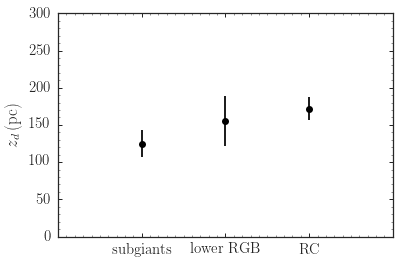

In [68]:
figsize(6,4)
tnpop= npop-1
skip= 1
bovy_plot.bovy_plot(numpy.arange(tnpop),
                    1000.*numpy.exp(all_p_cb[:tnpop:skip,1]),
                    'ko',
                    xrange=[-1,tnpop],
                    yrange=[0.,300.],
                    ylabel=r'$z_d\,(\mathrm{pc})$')
errorbar(numpy.arange(tnpop),
                    1000.*numpy.exp(all_p_cb[:tnpop:skip,1]),
        yerr=1000.*0.5*(numpy.exp(all_s_high_cb[:tnpop:skip,1])-numpy.exp(all_s_low_cb[:tnpop:skip,1])),
        marker='None',ls='None',capsize=0,color='k')
gca().xaxis.set_ticks(numpy.arange(tnpop))
_= gca().xaxis.set_ticklabels(labels[:tnpop])

The Sun's height above the plane is more uncertain and slightly higher, but not by much. It certainly does not become consistent with the Sun's height above the plane defined by A and F dwarfs:

(array([ 40.62911871,  26.17412925,  32.95580165]), array([  6.78387622,  15.73902633,   6.93203781]))
(33.429198704612233, 3.5282621709615412, 35.947844251706215, 4.6335850937247995)


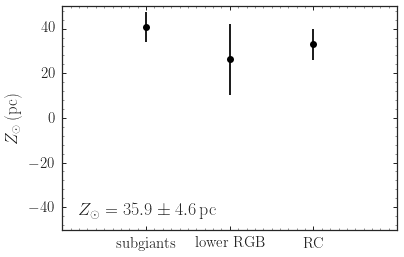

In [69]:
figsize(6,4)
bovy_plot.bovy_plot(numpy.arange(tnpop),
                    1000.*all_p_cb[:tnpop:skip,2],
                    'ko',
                    xrange=[-1,tnpop],
                    yrange=[-50.,50.],
                    ylabel=r'$Z_\odot\,(\mathrm{pc})$')
yerr= 1000.*0.5*((all_s_high_cb[:tnpop:skip,2])-(all_s_low_cb[:tnpop:skip,2]))
errorbar(numpy.arange(tnpop),
         1000.*(all_p_cb[:tnpop:skip,2]),
        yerr=yerr,
        marker='None',ls='None',capsize=0,color='k')
skip= 1
zsun_med= numpy.nanmedian(all_s_med_cb[:tnpop:skip,2])*1000.
zsun_mad= numpy.nanmedian(numpy.fabs(1000.*all_s_med_cb[:tnpop:skip,2]-zsun_med))/1.4826
zsun_mean= numpy.sum(1000.*all_p_cb[:tnpop:skip,2]/yerr[::skip]**2.)/numpy.sum(1./yerr[::skip]**2.)
zsun_std= numpy.sqrt(1./numpy.sum(1./yerr[::skip]**2.))
bovy_plot.bovy_text(r'$Z_\odot = %.1f \pm %.1f\,\mathrm{pc}$' % (zsun_mean,zsun_std),
                   bottom_left=True,size=18.)
print(1000.*all_p_cb[:tnpop:skip,2],yerr[::skip])
print(zsun_med,zsun_mad,zsun_mean,zsun_std)
gca().xaxis.set_ticks(numpy.arange(tnpop))
_= gca().xaxis.set_ticklabels(labels[:tnpop])